# Entrainement des modèles

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import json

sns.set()


data = pd.read_csv('donneeIngFeaturing.csv', sep='\t')
targetEMI = "logEMI"
targetCONSO = "logCONSO"

## étude avec ENERGY STAR

In [2]:

data = data.drop(columns = ["Unnamed: 0", "Unnamed: 1"])
dataStar = data.dropna()
dataNoStar = data.drop(columns=["ENERGYSTARScore"]).dropna()

In [3]:
dataStar.columns

Index(['OSEBuildingID', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore',
       'GHGEmissions(MetricTonsCO2e)', 'ConsoSourceBrute', 'logEMI',
       'logCONSO', 'sqrtNbFloor', 'sqrtNbBuild', 'logGFAPark', 'logGFABuild',
       'UType_Hotel', 'UType_K-12 School', 'UType_Multifamily Housing',
       'UType_Non-Refrigerated Warehouse', 'UType_Office', 'UType_Other',
       'UType_Parking', 'UType_Restaurant', 'UType_Retail Store',
       'BType_Multifamily HR (10+)', 'BType_Multifamily LR (1-4)',
       'BType_Multifamily MR (5-9)', 'BType_NonResidential',
       'BType_Nonresidential COS', 'BType_SPS-District K-12'],
      dtype='object')

### Isolation d'un set de données test X_test et y_test

In [4]:
categorical_features = dataStar.columns[16:].to_list()

In [5]:
categorical_features

['UType_Hotel',
 'UType_K-12 School',
 'UType_Multifamily Housing',
 'UType_Non-Refrigerated Warehouse',
 'UType_Office',
 'UType_Other',
 'UType_Parking',
 'UType_Restaurant',
 'UType_Retail Store',
 'BType_Multifamily HR (10+)',
 'BType_Multifamily LR (1-4)',
 'BType_Multifamily MR (5-9)',
 'BType_NonResidential',
 'BType_Nonresidential COS',
 'BType_SPS-District K-12']

In [6]:
from sklearn.model_selection import train_test_split

numerical_features = ['CouncilDistrictCode', 'YearBuilt','sqrtNbBuild', 
                      'sqrtNbFloor', 'ENERGYSTARScore','logGFAPark', 'logGFABuild']

categorical_features = dataStar.columns[16:].to_list()


X = dataStar[numerical_features + categorical_features]
y = dataStar[[targetEMI] + [targetCONSO]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3972, 22)
(993, 22)
(3972, 2)
(993, 2)


In [7]:
y_trainCONSO = y_train[targetCONSO]
y_trainEMI = y_train[targetEMI]

print(y_trainCONSO.shape)
print(y_trainEMI.shape)

(3972,)
(3972,)


In [8]:
X_train.to_csv('X_train.csv', sep='\t', encoding='utf-8')
y_trainEMI.to_csv('Y_trainEMI.csv', sep='\t', encoding='utf-8')
y_trainCONSO.to_csv('Y_trainCONSO.csv', sep='\t', encoding='utf-8')

X_test.to_csv('X_test.csv', sep='\t', encoding='utf-8')
y_test.to_csv('Y_test.csv', sep='\t', encoding='utf-8')

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


### creation pipeline transformer

In [9]:
X_train.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'ENERGYSTARScore', 'logGFAPark', 'logGFABuild', 'UType_Hotel',
       'UType_K-12 School', 'UType_Multifamily Housing',
       'UType_Non-Refrigerated Warehouse', 'UType_Office', 'UType_Other',
       'UType_Parking', 'UType_Restaurant', 'UType_Retail Store',
       'BType_Multifamily HR (10+)', 'BType_Multifamily LR (1-4)',
       'BType_Multifamily MR (5-9)', 'BType_NonResidential',
       'BType_Nonresidential COS', 'BType_SPS-District K-12'],
      dtype='object')

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(StandardScaler())
# categorical_pipeline = make_pipeline(FunctionTransformer())


In [11]:
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

### Evaluation des modèles avec validation croisées et comparaison avec eds approche de regression naives

#### Initialisation tableau ERROR

In [12]:
ERROR_EMI = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
ERROR_CONSO = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

#### modele linéaire 

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS


model_ML = LinearRegression()


In [14]:

import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'LinearRegression'

##### Emission

In [15]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train , y_train)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [16]:
grid.cv_results_

{'mean_fit_time': array([0.03037701]),
 'std_fit_time': array([0.03561343]),
 'mean_score_time': array([0.00673695]),
 'std_score_time': array([0.00157524]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-0.93505228]),
 'split1_test_neg_root_mean_squared_error': array([-0.93925932]),
 'split2_test_neg_root_mean_squared_error': array([-0.91352873]),
 'split3_test_neg_root_mean_squared_error': array([-0.93726821]),
 'split4_test_neg_root_mean_squared_error': array([-0.89749707]),
 'mean_test_neg_root_mean_squared_error': array([-0.92452112]),
 'std_test_neg_root_mean_squared_error': array([0.01638133]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.62001655]),
 'split1_test_r2': array([0.57458893]),
 'split2_test_r2': array([0.58497598]),
 'split3_test_r2': array([0.58145475]),
 'split4_test_r2': array([0.59424104]),
 'mean_test_r2': array([0.59105545]),
 'std_test_r2': array([0.01580616]),
 'rank_test_r2': array([1],

In [17]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [18]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [19]:
ERROR_EMI

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598]]}

##### Consomation

In [20]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train , y_train)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [21]:
grid.cv_results_

{'mean_fit_time': array([0.01248236]),
 'std_fit_time': array([0.00038039]),
 'mean_score_time': array([0.00598454]),
 'std_score_time': array([0.00022083]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-0.41785127]),
 'split1_test_neg_root_mean_squared_error': array([-0.42904103]),
 'split2_test_neg_root_mean_squared_error': array([-0.37240097]),
 'split3_test_neg_root_mean_squared_error': array([-0.47066064]),
 'split4_test_neg_root_mean_squared_error': array([-0.37404812]),
 'mean_test_neg_root_mean_squared_error': array([-0.4128004]),
 'std_test_neg_root_mean_squared_error': array([0.03679927]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.87713247]),
 'split1_test_r2': array([0.85038089]),
 'split2_test_r2': array([0.89550061]),
 'split3_test_r2': array([0.83463417]),
 'split4_test_r2': array([0.87985932]),
 'mean_test_r2': array([0.86750149]),
 'std_test_r2': array([0.02192167]),
 'rank_test_r2': array([1], 

In [22]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [23]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [24]:
ERROR_CONSO

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697]]}

#### modele linaire avec Elastic Net

In [25]:
from sklearn.linear_model import ElasticNet

model_ML = ElasticNet()


In [26]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'ElasticNet'

In [27]:
model = make_pipeline(preprocessor,model_ML)
model

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [28]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1331.5812291806435, tolerance: 0.6499231844136567
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1327.529527039896, tolerance: 0.6682609929828525
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1349.3182194986005, tolerance: 0.6730717539721366
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.3887199254475, tolerance: 0.6499231844136567
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.71620105991792, tolerance: 0.6682609929828525
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.04648288149747, tolerance: 0.6730717539721366
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numb

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1542.380023269963, tolerance: 0.6749704618105119
  positive)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [29]:
paramList = list(params.keys())


In [30]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.5911079 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000

Le meilleur score de RMSE est : -0.9244544 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000

Le meilleur score de MAE est : -0.7594969 pour les paramètres alpha 0.0001000 et l1_ratio 0.5000000


In [31]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


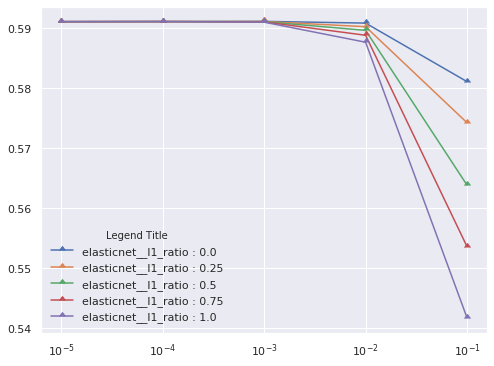

In [32]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


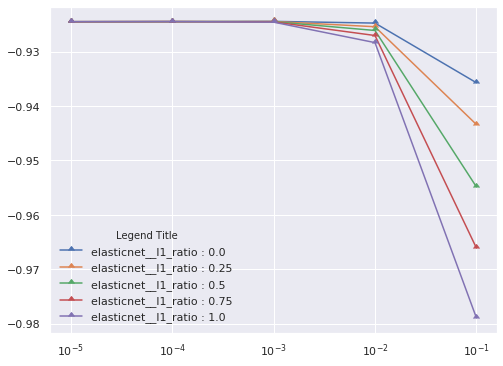

In [33]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


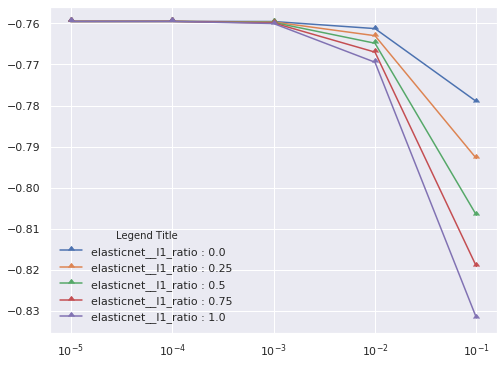

In [34]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [35]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [36]:
ERROR_EMI

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891]]}

##### Consomation

In [37]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.65567371785824, tolerance: 0.40212845495560634
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.9637776304428, tolerance: 0.4173016779625319
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281.54991347920065, tolerance: 0.4097585773275481
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9870106507752325, tolerance: 0.40212845495560634
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7786721624877373, tolerance: 0.4097585773275481
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47986929955447977, tolerance: 0.40212845495560634
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase th

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [38]:
paramList = list(params.keys())


In [39]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.8676243 pour les paramètres alpha 0.0010000 et l1_ratio 1.0000000

Le meilleur score de RMSE est : -0.4125847 pour les paramètres alpha 0.0010000 et l1_ratio 1.0000000

Le meilleur score de MAE est : -0.2623636 pour les paramètres alpha 0.0100000 et l1_ratio 1.0000000


In [40]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


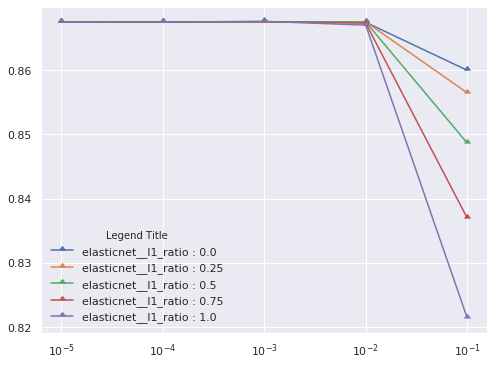

In [41]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


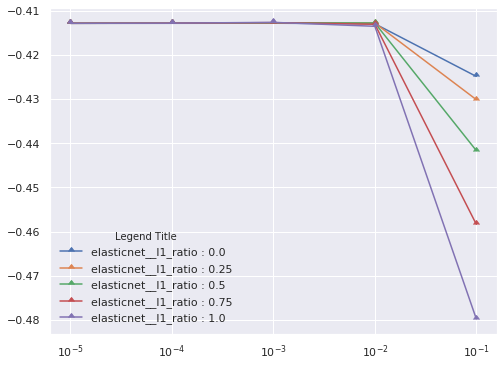

In [42]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


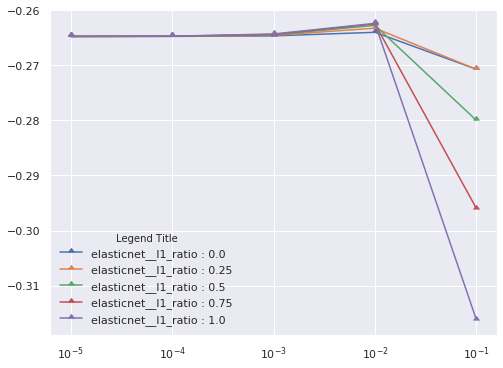

In [43]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [44]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [45]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114]]}

#### modele linaire avec SVR

In [46]:
from sklearn.svm import SVR
model_ML = SVR()

In [47]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0) + "lin"
model_name

'SVRlin'

In [48]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [49]:

params = {
    "svr__C" : np.logspace(-1, 2, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [50]:
grid.cv_results_

{'mean_fit_time': array([1.00258856, 1.06006098, 1.20985475, 2.0229351 , 5.49147182]),
 'std_fit_time': array([0.0090167 , 0.00811054, 0.01663962, 0.04311619, 0.21570297]),
 'mean_score_time': array([0.14312973, 0.13378758, 0.13127136, 0.13105235, 0.12429118]),
 'std_score_time': array([0.00223183, 0.00030195, 0.00045977, 0.00514327, 0.00171318]),
 'param_svr__C': masked_array(data=[0.1, 0.5623413251903491, 3.1622776601683795,
                    17.78279410038923, 100.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.1},
  {'svr__C': 0.5623413251903491},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 17.78279410038923},
  {'svr__C': 100.0}],
 'split0_test_neg_root_mean_squared_error': array([-0.96237135, -0.89664992, -0.86555576, -0.8579962 , -0.88864388]),
 'split1_test_neg_root_mean_squared_error': array([-0.97048606, -0.92361251, -0.92076981, -0.93693625, -0.99099306]),
 'split2_test_neg_root_mea

In [51]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [52]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6381827 pour les paramètres svr__C : 3.1622777

Le meilleur score de RMSE est : -0.8690911 pour les paramètres svr__C : 3.1622777

Le meilleur score de MAE est : -0.6149806 pour les paramètres svr__C : 100.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


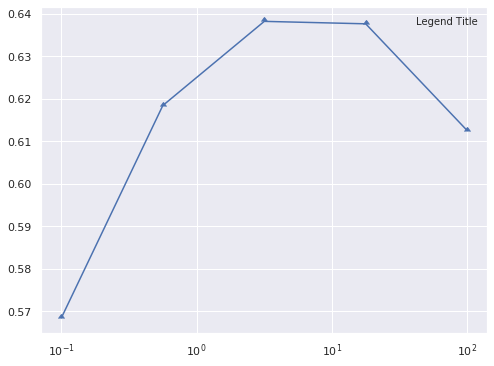

In [53]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


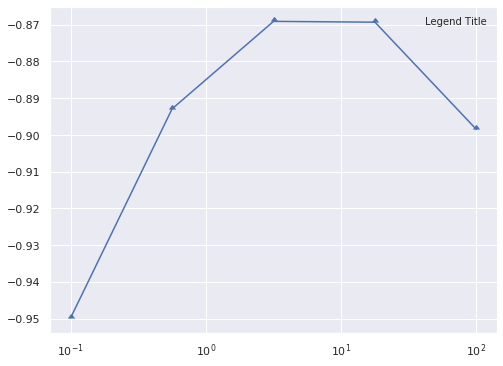

In [54]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


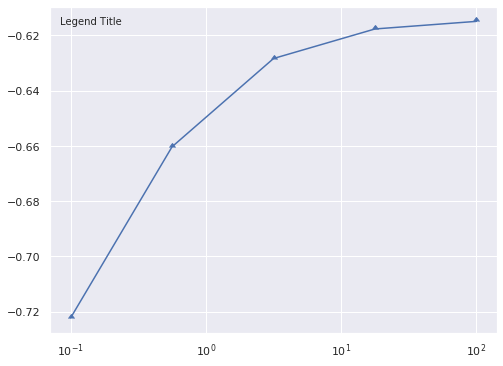

In [55]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [56]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [57]:
ERROR_EMI

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718]]}

##### Consomation

In [58]:

params = {
    "svr__C" : np.logspace(-2, 3, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [59]:
grid.cv_results_

{'mean_fit_time': array([ 0.92064724,  0.72908311,  1.04840703,  4.69364004, 41.23084555]),
 'std_fit_time': array([0.02307919, 0.03159059, 0.01090027, 0.51474378, 2.33560466]),
 'mean_score_time': array([0.15012984, 0.10273485, 0.09108887, 0.08255243, 0.06636529]),
 'std_score_time': array([0.03720221, 0.00197559, 0.00078487, 0.00982326, 0.00098185]),
 'param_svr__C': masked_array(data=[0.01, 0.1778279410038923, 3.1622776601683795,
                    56.23413251903491, 1000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.01},
  {'svr__C': 0.1778279410038923},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 56.23413251903491},
  {'svr__C': 1000.0}],
 'split0_test_neg_root_mean_squared_error': array([-0.77691413, -0.46757381, -0.37195424, -0.40016827, -0.50092906]),
 'split1_test_neg_root_mean_squared_error': array([-0.70206538, -0.45578737, -0.39125021, -0.41259814, -0.49951054]),
 'split2_test_neg

In [60]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [61]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8909603 pour les paramètres svr__C : 3.1622777

Le meilleur score de RMSE est : -0.3737817 pour les paramètres svr__C : 3.1622777

Le meilleur score de MAE est : -0.2155408 pour les paramètres svr__C : 3.1622777


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


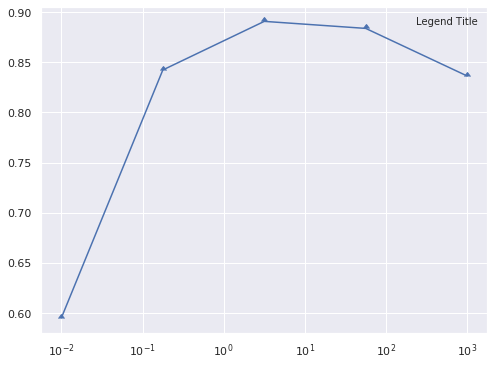

In [62]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


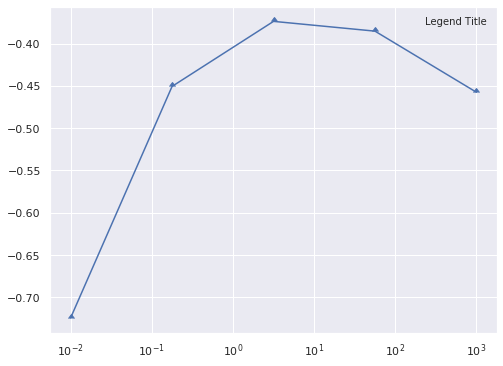

In [63]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


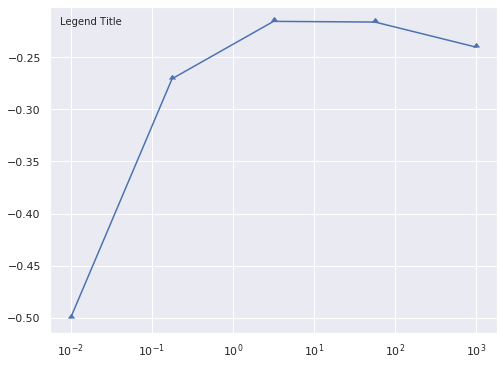

In [64]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [65]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [66]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197]]}

#### modele KNN 

In [67]:
from sklearn.neighbors import KNeighborsRegressor
model_ML = KNeighborsRegressor()

In [68]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KNeighborsRegressor'

In [69]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [70]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,40),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [71]:
grid.cv_results_

{'mean_fit_time': array([0.03428626, 0.03352246, 0.03522577, 0.03541341, 0.03527603,
        0.03613949, 0.0346662 , 0.03545408, 0.03465152, 0.03482661,
        0.03504615, 0.03457694, 0.03542409, 0.0347167 , 0.03457417,
        0.03471146, 0.03480272, 0.03500066, 0.03463769, 0.0346117 ,
        0.03483543, 0.0349946 , 0.03470654, 0.03458524, 0.03381352,
        0.02851839, 0.02648854, 0.02575026, 0.02504621, 0.02523675,
        0.02501287, 0.02526288, 0.0250845 , 0.02504711, 0.0256135 ,
        0.02575731, 0.02505593, 0.0250834 , 0.02508125]),
 'std_fit_time': array([1.48013931e-03, 1.32343454e-03, 9.02045452e-04, 7.29174630e-04,
        7.80930098e-04, 5.32414792e-04, 1.26191835e-04, 9.37643286e-04,
        1.55073353e-04, 8.14663392e-04, 8.25211600e-04, 1.43664112e-04,
        1.83275288e-03, 1.08341411e-04, 1.85883124e-04, 2.15159451e-04,
        4.00655634e-04, 7.05993647e-04, 9.58087960e-05, 1.25793492e-04,
        2.10484510e-04, 4.92579501e-04, 1.74697439e-04, 4.43048826e-04,
 

In [72]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [73]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5784485 pour les paramètres kneighborsregressor__n_neighbors : 5.0000000

Le meilleur score de RMSE est : -0.9385408 pour les paramètres kneighborsregressor__n_neighbors : 5.0000000

Le meilleur score de MAE est : -0.5550373 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


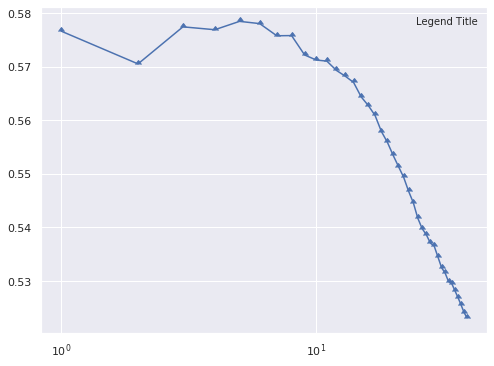

In [74]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


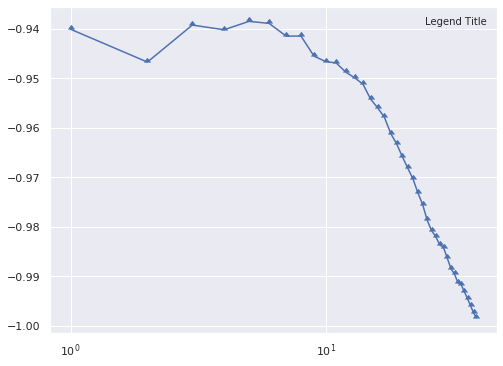

In [75]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


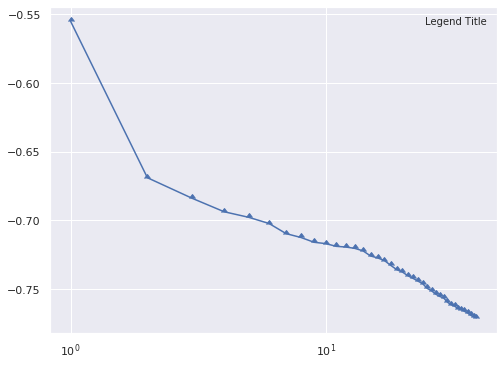

In [76]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [77]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [78]:
ERROR_EMI

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625]]}

##### Consomation

In [79]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,20),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [80]:
grid.cv_results_

{'mean_fit_time': array([0.03346086, 0.03319535, 0.0335927 , 0.03373089, 0.03383384,
        0.03414111, 0.03382163, 0.03397794, 0.0337347 , 0.03322439,
        0.03344178, 0.03310981, 0.03435884, 0.03313918, 0.03366799,
        0.03321033, 0.03307366, 0.03320289, 0.03299789]),
 'std_fit_time': array([0.00029114, 0.0002673 , 0.00097618, 0.00059426, 0.0008974 ,
        0.00079345, 0.00064304, 0.00072727, 0.00057094, 0.00056309,
        0.00062679, 0.00020946, 0.00141234, 0.00025488, 0.0009237 ,
        0.00026825, 0.00016258, 0.00031404, 0.00016844]),
 'mean_score_time': array([0.10633831, 0.10933862, 0.11411033, 0.11200566, 0.11478033,
        0.1205183 , 0.11692634, 0.12462373, 0.11782317, 0.11832628,
        0.11785274, 0.11864781, 0.12157445, 0.11926408, 0.12230144,
        0.12086215, 0.12120423, 0.12201333, 0.12231822]),
 'std_score_time': array([0.00199724, 0.00187003, 0.00088903, 0.00143836, 0.00242877,
        0.00537917, 0.00308233, 0.00666249, 0.00271992, 0.00188134,
        

In [81]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [82]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8110678 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de RMSE est : -0.4938113 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de MAE est : -0.2747882 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


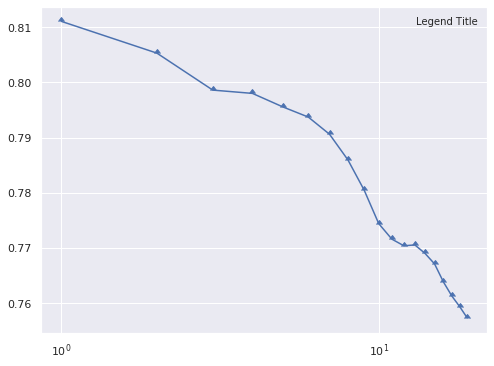

In [83]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


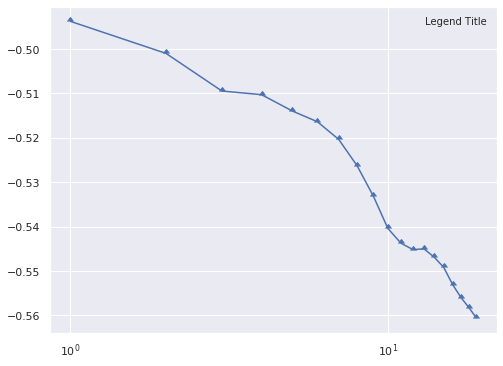

In [84]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


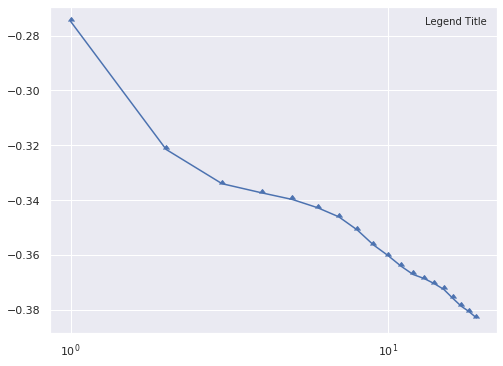

In [85]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [86]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [87]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197],
  [0.8110678027919672, -0.493811345915498, -0.2747881898197785]]}

In [88]:
ERROR_CONSO

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197],
  [0.8110678027919672, -0.493811345915498, -0.2747881898197785]]}

#### modele non linéaire La régression ridge à noyau

In [89]:
from sklearn import kernel_ridge
model_ML = kernel_ridge.KernelRidge()
       

In [90]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KernelRidge'

In [91]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [92]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [93]:
grid.cv_results_

{'mean_fit_time': array([0.60041084, 0.64764132, 0.63788586, 0.63602428, 0.63324757,
        0.62709298, 0.62101769, 0.59304566, 0.5882699 , 0.58612652,
        0.58566961, 0.53023982, 0.4746151 , 0.47316136, 0.47321181,
        0.47332778, 0.47137017, 0.47092152, 0.52867928, 0.49386048,
        0.4735899 , 0.4713685 , 0.47143717, 0.47136998, 0.47218204]),
 'std_fit_time': array([0.02514074, 0.00556744, 0.01182106, 0.0151794 , 0.00816296,
        0.00747426, 0.02035483, 0.00550243, 0.00225764, 0.00114964,
        0.0029622 , 0.05394949, 0.00207224, 0.00283989, 0.00223258,
        0.00259255, 0.001461  , 0.00139549, 0.05183708, 0.01674279,
        0.00327636, 0.00300705, 0.00166404, 0.0012016 , 0.0020437 ]),
 'mean_score_time': array([0.04894009, 0.04952359, 0.04889364, 0.04879785, 0.04873672,
        0.048909  , 0.04971466, 0.0441608 , 0.04402218, 0.04424181,
        0.04418082, 0.04168801, 0.03695116, 0.0369503 , 0.03695288,
        0.03691759, 0.03695822, 0.03694758, 0.04440112, 0.03

In [94]:
grid.cv_results_

{'mean_fit_time': array([0.60041084, 0.64764132, 0.63788586, 0.63602428, 0.63324757,
        0.62709298, 0.62101769, 0.59304566, 0.5882699 , 0.58612652,
        0.58566961, 0.53023982, 0.4746151 , 0.47316136, 0.47321181,
        0.47332778, 0.47137017, 0.47092152, 0.52867928, 0.49386048,
        0.4735899 , 0.4713685 , 0.47143717, 0.47136998, 0.47218204]),
 'std_fit_time': array([0.02514074, 0.00556744, 0.01182106, 0.0151794 , 0.00816296,
        0.00747426, 0.02035483, 0.00550243, 0.00225764, 0.00114964,
        0.0029622 , 0.05394949, 0.00207224, 0.00283989, 0.00223258,
        0.00259255, 0.001461  , 0.00139549, 0.05183708, 0.01674279,
        0.00327636, 0.00300705, 0.00166404, 0.0012016 , 0.0020437 ]),
 'mean_score_time': array([0.04894009, 0.04952359, 0.04889364, 0.04879785, 0.04873672,
        0.048909  , 0.04971466, 0.0441608 , 0.04402218, 0.04424181,
        0.04418082, 0.04168801, 0.03695116, 0.0369503 , 0.03695288,
        0.03691759, 0.03695822, 0.03694758, 0.04440112, 0.03

In [95]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [96]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6520819 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de RMSE est : -0.8519603 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de MAE est : -0.6365940 pour les paramètres kernelridge__alpha : 0.0031623 et kernelridge__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


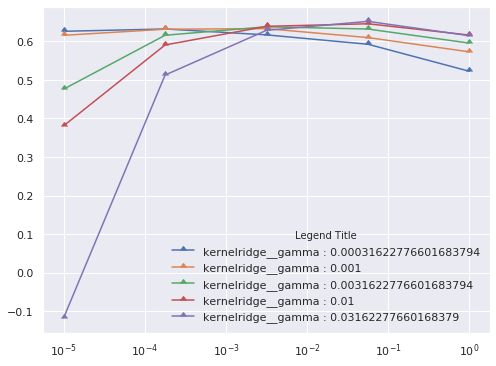

In [97]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


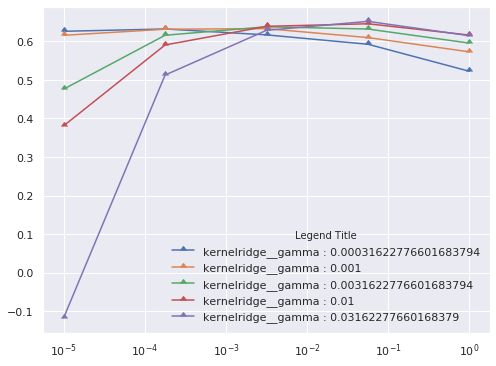

In [98]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


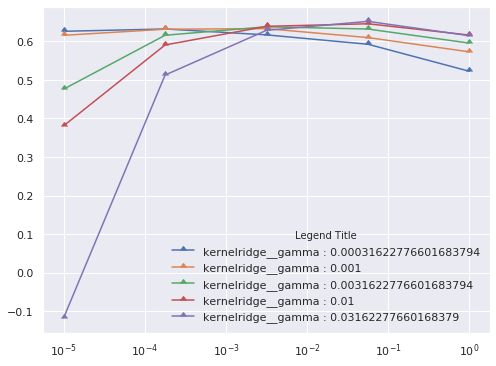

In [99]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [100]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [101]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
  [0.6520819442305585, -0.8519603321725377, -0.6365940379052029]]}

##### Consomation 

In [102]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [103]:
grid.cv_results_

{'mean_fit_time': array([ 0.49241781,  0.53960986,  0.5404716 ,  0.54673429,  0.54149475,
         0.53900027,  0.53673182,  0.53808403,  0.54567146,  0.53921885,
         0.5382885 ,  0.51725512,  0.49053993,  0.48789425, 14.2388526 ,
         0.51512966,  0.71244617,  0.7162591 ,  0.79007573,  0.82181883,
         0.89498115,  0.84039278,  0.75893354,  0.66140289,  0.56127892]),
 'std_fit_time': array([3.44841781e-02, 4.46298924e-03, 6.43464280e-03, 1.11598372e-02,
        9.16880898e-03, 4.35772829e-03, 4.76593648e-03, 5.68637654e-03,
        9.94388906e-03, 2.11958417e-03, 3.17006580e-03, 2.11279897e-02,
        2.97565962e-02, 1.65697706e-02, 2.77351822e+01, 6.25626563e-02,
        7.86796595e-02, 1.03407343e-01, 5.86942392e-02, 4.01133757e-02,
        6.36406695e-02, 4.22954770e-02, 6.89546409e-02, 5.70436637e-02,
        4.03970356e-02]),
 'mean_score_time': array([0.04038162, 0.04234962, 0.04237752, 0.04275966, 0.04232373,
        0.04344597, 0.04240541, 0.04268727, 0.04260488,

In [104]:
grid.cv_results_

{'mean_fit_time': array([ 0.49241781,  0.53960986,  0.5404716 ,  0.54673429,  0.54149475,
         0.53900027,  0.53673182,  0.53808403,  0.54567146,  0.53921885,
         0.5382885 ,  0.51725512,  0.49053993,  0.48789425, 14.2388526 ,
         0.51512966,  0.71244617,  0.7162591 ,  0.79007573,  0.82181883,
         0.89498115,  0.84039278,  0.75893354,  0.66140289,  0.56127892]),
 'std_fit_time': array([3.44841781e-02, 4.46298924e-03, 6.43464280e-03, 1.11598372e-02,
        9.16880898e-03, 4.35772829e-03, 4.76593648e-03, 5.68637654e-03,
        9.94388906e-03, 2.11958417e-03, 3.17006580e-03, 2.11279897e-02,
        2.97565962e-02, 1.65697706e-02, 2.77351822e+01, 6.25626563e-02,
        7.86796595e-02, 1.03407343e-01, 5.86942392e-02, 4.01133757e-02,
        6.36406695e-02, 4.22954770e-02, 6.89546409e-02, 5.70436637e-02,
        4.03970356e-02]),
 'mean_score_time': array([0.04038162, 0.04234962, 0.04237752, 0.04275966, 0.04232373,
        0.04344597, 0.04240541, 0.04268727, 0.04260488,

In [105]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [106]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8888415 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0010000

Le meilleur score de RMSE est : -0.3757307 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0010000

Le meilleur score de MAE est : -0.2183112 pour les paramètres kernelridge__alpha : 0.0001778 et kernelridge__gamma : 0.0031623


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


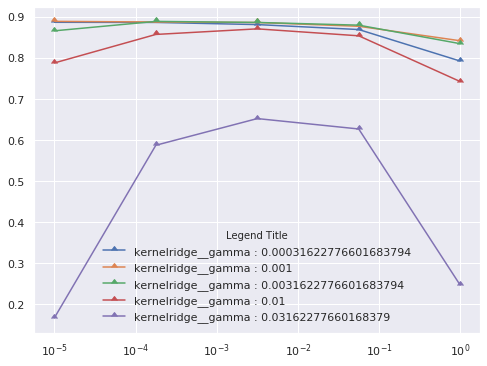

In [107]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


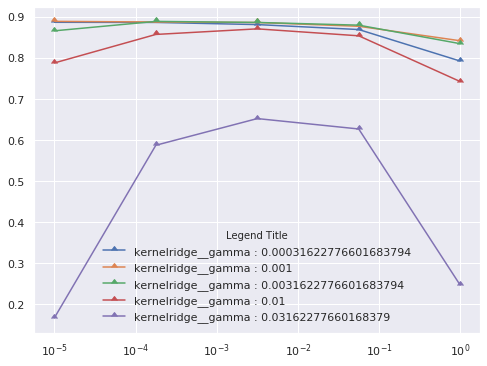

In [108]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


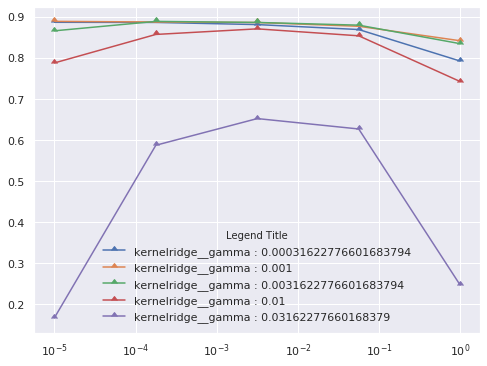

In [109]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [110]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [111]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197],
  [0.8110678027919672, -0.493811345915498, -0.2747881898197785],
  [0.8888414540279775, -0.37573070790117125, -0.2183112337530997]]}

#### modele non linéaire : SVR

In [112]:
from sklearn.svm import SVR
model_ML = SVR()
                                     


In [113]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'SVR'

In [114]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [115]:



params = {
    "svr__C" : np.logspace(-1, 2, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 3)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [116]:
grid.cv_results_

{'mean_fit_time': array([1.17438302, 1.19698296, 1.30944896, 0.90250711, 0.77662358,
        0.77524281, 0.92044144, 0.89992075, 1.02362919, 0.82420163,
        0.99685912, 1.70593662, 0.97392182, 1.48341069, 3.91712441]),
 'std_fit_time': array([0.04778695, 0.1132977 , 0.14864729, 0.08371255, 0.03948479,
        0.00541229, 0.12675335, 0.03607474, 0.14530971, 0.02231529,
        0.072926  , 0.16497393, 0.10713079, 0.08695734, 0.28610765]),
 'mean_score_time': array([0.19147739, 0.17979441, 0.17949691, 0.12728949, 0.10751414,
        0.10286493, 0.13131084, 0.11576324, 0.1235312 , 0.11416345,
        0.11655169, 0.12665253, 0.12398643, 0.10868526, 0.10694032]),
 'std_score_time': array([0.0392709 , 0.03813472, 0.02445847, 0.00603411, 0.00275361,
        0.00159839, 0.01376088, 0.0040473 , 0.02602004, 0.00696779,
        0.00923161, 0.01980761, 0.02029607, 0.00724475, 0.00807954]),
 'param_svr__C': masked_array(data=[0.1, 0.1, 0.1, 0.5623413251903491, 0.5623413251903491,
               

In [117]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [118]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6361119 pour les paramètres svr__C : 3.1622777 et svr__gamma : 0.0316228

Le meilleur score de RMSE est : -0.8716466 pour les paramètres svr__C : 3.1622777 et svr__gamma : 0.0316228

Le meilleur score de MAE est : -0.6225900 pour les paramètres svr__C : 100.0000000 et svr__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


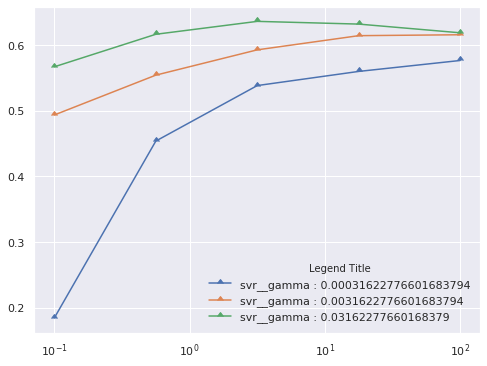

In [119]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


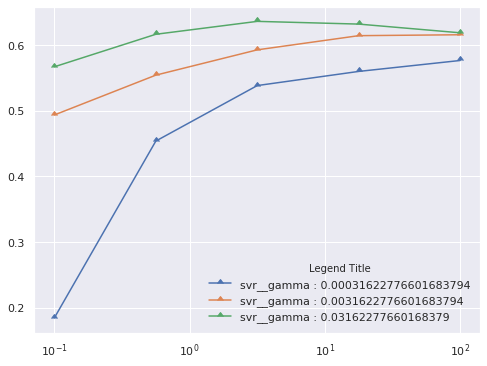

In [120]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


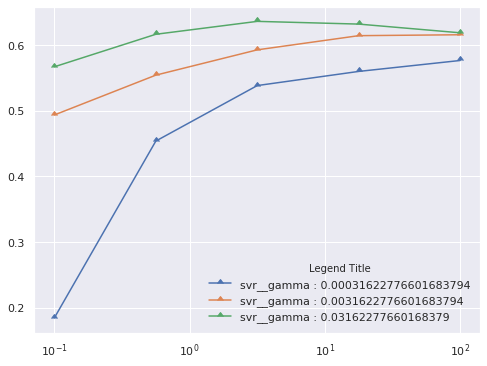

In [121]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [122]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [123]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
  [0.6520819442305585, -0.8519603321725377, -0.6365940379052029],
  [0.6361119245585076, -0.8716466411141109, -0.6225900260052712]]}

##### Consomation

In [124]:



params = {
    "svr__C" : np.logspace(-2, 3, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 5)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [125]:
grid.cv_results_

{'mean_fit_time': array([ 1.0403595 ,  1.06799908,  0.88717375,  0.77258887,  0.75660615,
         0.7333416 ,  0.66887484,  0.77621603,  0.68723893,  0.56263623,
         0.58520803,  0.63885975,  0.59963865,  0.7203517 ,  0.73000507,
         0.76940932,  0.78974662,  1.15679712,  1.86983895,  3.15477977,
         1.76351199,  3.84742575,  7.79867945, 20.29814243, 40.79180446]),
 'std_fit_time': array([0.02513431, 0.05925102, 0.05573861, 0.04617109, 0.10622823,
        0.00561326, 0.06560521, 0.08014599, 0.0673873 , 0.02917209,
        0.03011097, 0.04064402, 0.00632056, 0.08431466, 0.0110443 ,
        0.07359496, 0.03236655, 0.01230124, 0.05570444, 0.1793178 ,
        0.05434428, 0.12459546, 0.38678454, 1.8087455 , 2.82161893]),
 'mean_score_time': array([0.14710269, 0.14690723, 0.13121696, 0.1175632 , 0.10396514,
        0.10394406, 0.09281368, 0.10937657, 0.09452081, 0.07942567,
        0.08234658, 0.08509226, 0.07740002, 0.07674813, 0.06828284,
        0.08949757, 0.07179608, 0.0

In [126]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [127]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8920072 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0100000

Le meilleur score de RMSE est : -0.3705333 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0100000

Le meilleur score de MAE est : -0.2109355 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


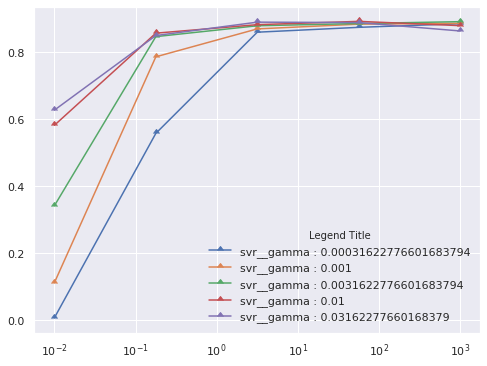

In [128]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


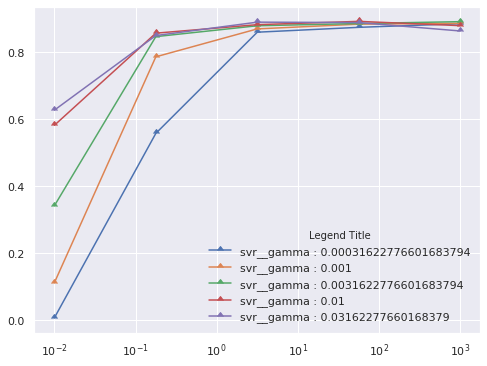

In [129]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


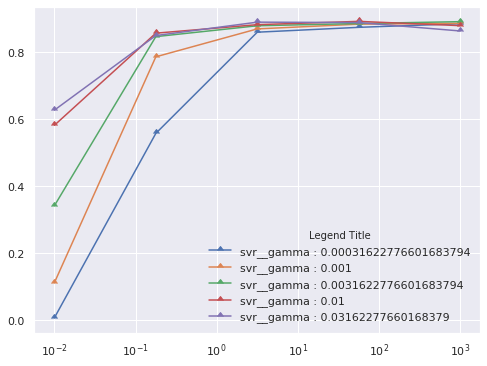

In [130]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [131]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [132]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197],
  [0.8110678027919672, -0.493811345915498, -0.2747881898197785],
  [0.8888414540279775, -0.37573070790117125, -0.2183112337530997],
  [0.8920072191502886, -0.3705332544678228, -0.21093548610554133]]}

#### modele non linéaire : réseau de neurones

In [133]:

from sklearn.neural_network import MLPRegressor


model_ML = MLPRegressor()

In [134]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'MLPRegressor'

In [135]:

model = make_pipeline(preprocessor,model_ML)
print(model.steps)


[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor',
                                  'ENERGYSTARScore', 'logGFAPark',
                                  'logGFABuild']),
                                (...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  '

In [136]:



params = {
    'mlpregressor__max_iter': [50,80, 100,150,200,300],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['logistic'],
    'mlpregressor__solver': ["lbfgs"],
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [137]:
grid.cv_results_

{'mean_fit_time': array([0.32817855, 0.55059781, 0.64708071, 0.98306689, 1.31517005,
        1.31078019, 0.38406343, 0.59398613, 0.71140842, 1.09112825,
        1.4518034 , 2.16131067, 0.55498419, 0.89722419, 1.12156439,
        1.63518214, 2.20618572, 3.27533336]),
 'std_fit_time': array([0.02397102, 0.0175158 , 0.00837046, 0.02419202, 0.01446794,
        0.27413388, 0.01252838, 0.00579972, 0.01301303, 0.01211196,
        0.00820149, 0.0261974 , 0.01888239, 0.00471165, 0.05184747,
        0.06013787, 0.07206093, 0.11222972]),
 'mean_score_time': array([0.0113833 , 0.01228075, 0.01077971, 0.01258073, 0.01298342,
        0.00820308, 0.00819955, 0.00816693, 0.0080956 , 0.0086267 ,
        0.00818076, 0.00815444, 0.00843434, 0.00869851, 0.00872555,
        0.0088551 , 0.0087677 , 0.00993462]),
 'std_score_time': array([0.00152625, 0.00105527, 0.00027279, 0.00090491, 0.00038045,
        0.00112745, 0.00026901, 0.00035163, 0.00041784, 0.00104482,
        0.0002267 , 0.00021517, 0.00015234, 

In [138]:
paramList = list(params.keys())
np.shape(paramList)[0]

4

In [139]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.6668241 pour les paramètres mlpregressor__max_iter : 100.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)

Le meilleur score de RMSE est : -0.8341556 pour les paramètres mlpregressor__max_iter : 100.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)

Le meilleur score de MAE est : -0.6338833 pour les paramètres mlpregressor__max_iter : 150.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


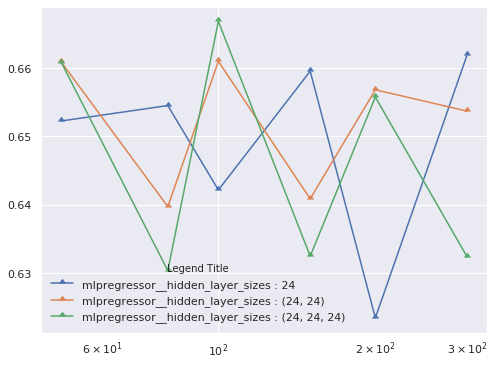

In [140]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


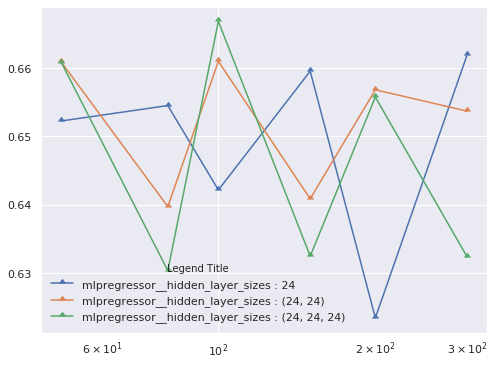

In [141]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


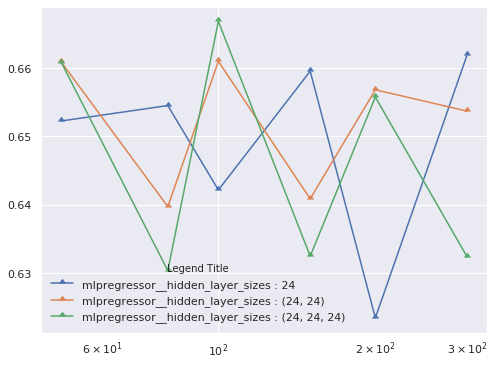

In [142]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [143]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [144]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
  [0.6520819442305585, -0.8519603321725377, -0.6365940379052029],
  [0.6361119245585076, -0.8716466411141109, -0.6225900260052712],
  [0.6668241309444778, -0.8341555958096161, -0.6338833117127363]]}

##### Consomation

In [145]:



params = {
    'mlpregressor__max_iter': [50,80, 100,150,200,300],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['logistic'],
    'mlpregressor__solver': ["lbfgs"],
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [146]:
grid.cv_results_

{'mean_fit_time': array([0.20324674, 0.34938006, 0.44061337, 0.68142476, 1.37077789,
        1.3568109 , 0.387708  , 0.81537323, 0.97574525, 1.48284426,
        1.5270946 , 2.19625039, 0.5805687 , 1.05167522, 1.46196079,
        1.87165084, 2.70032792, 3.26254706]),
 'std_fit_time': array([0.01182874, 0.00695586, 0.01724865, 0.04465246, 0.12766708,
        0.1794987 , 0.00397615, 0.09254474, 0.10467008, 0.11375515,
        0.06902649, 0.0211246 , 0.01895264, 0.15359582, 0.06587268,
        0.10837455, 0.37129427, 0.08595008]),
 'mean_score_time': array([0.00797014, 0.00832076, 0.00884027, 0.00908532, 0.01225162,
        0.00891862, 0.00845599, 0.01179514, 0.01164045, 0.01160684,
        0.00838161, 0.00913219, 0.00955529, 0.01108503, 0.01191459,
        0.00981555, 0.01060929, 0.00884089]),
 'std_score_time': array([0.00051323, 0.00032694, 0.00077075, 0.0009947 , 0.00254258,
        0.0015552 , 0.00022385, 0.00222441, 0.00299962, 0.00292667,
        0.00027644, 0.00188844, 0.00128816, 

In [147]:
paramList = list(params.keys())
np.shape(paramList)[0]

4

In [148]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]
    
    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8884913 pour les paramètres mlpregressor__max_iter : 150.0000000 et mlpregressor__hidden_layer_sizes : 24

Le meilleur score de RMSE est : -0.3775342 pour les paramètres mlpregressor__max_iter : 150.0000000 et mlpregressor__hidden_layer_sizes : 24

Le meilleur score de MAE est : -0.2341144 pour les paramètres mlpregressor__max_iter : 300.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


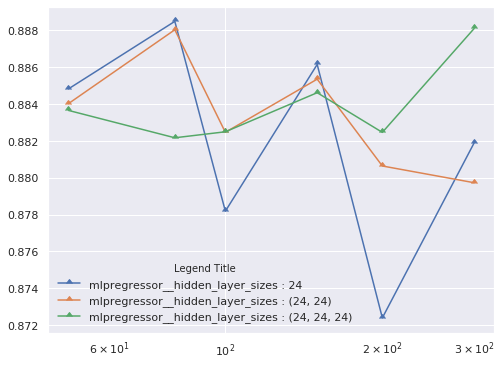

In [149]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


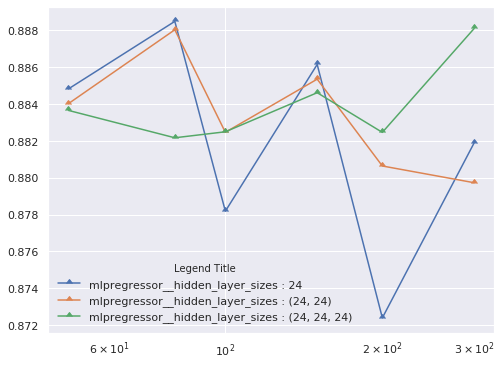

In [150]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


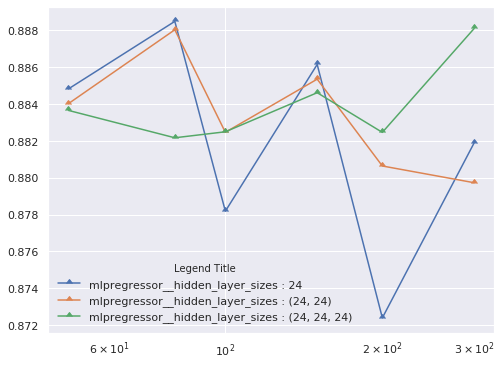

In [151]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [152]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [153]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197],
  [0.8110678027919672, -0.493811345915498, -0.2747881898197785],
  [0.8888414540279775, -0.37573070790117125, -0.2183112337530997],
  [0.8920072191502886, -0.3705332544678228, -0.21093548610554133],
  [0.8884913443806324, -0.37753420893191014, -0.23411440091183772]]}

#### forêts aléatoires

In [154]:
from sklearn.ensemble import RandomForestRegressor
model_ML = RandomForestRegressor()

In [155]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'RandomForestRegressor'

In [156]:
model = make_pipeline(preprocessor,model_ML)
print(model.steps)

[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor',
                                  'ENERGYSTARScore', 'logGFAPark',
                                  'logGFABuild']),
                                (...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  '

In [157]:



params = {
            'randomforestregressor__max_depth': [5,10, 15, 20, 22, 24],
            'randomforestregressor__n_estimators': (50, 100),    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [158]:
grid.cv_results_

{'mean_fit_time': array([0.35398302, 0.7141006 , 0.68941598, 1.25812654, 0.78166461,
        1.24063773, 0.70236259, 1.68292627, 0.69420667, 1.40985417,
        0.71031489, 1.62040906]),
 'std_fit_time': array([0.00483562, 0.03130943, 0.0278757 , 0.04743041, 0.08159647,
        0.05506123, 0.04745077, 0.15271195, 0.01466656, 0.09197937,
        0.02953232, 0.22260992]),
 'mean_score_time': array([0.01164927, 0.01749363, 0.01939178, 0.02369089, 0.01567845,
        0.0214736 , 0.01464119, 0.03151717, 0.01440158, 0.02491155,
        0.01510363, 0.02974992]),
 'std_score_time': array([0.00024064, 0.00119854, 0.00521812, 0.00094757, 0.00245638,
        0.0009381 , 0.00126335, 0.00701148, 0.00033802, 0.00218779,
        0.00108795, 0.00400834]),
 'param_randomforestregressor__max_depth': masked_array(data=[5, 5, 10, 10, 15, 15, 20, 20, 22, 22, 24, 24],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_val

In [159]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [160]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7670274 pour les paramètres randomforestregressor__max_depth : 22.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de RMSE est : -0.6975402 pour les paramètres randomforestregressor__max_depth : 22.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de MAE est : -0.5024894 pour les paramètres randomforestregressor__max_depth : 22.0000000 et randomforestregressor__n_estimators : 100.0000000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


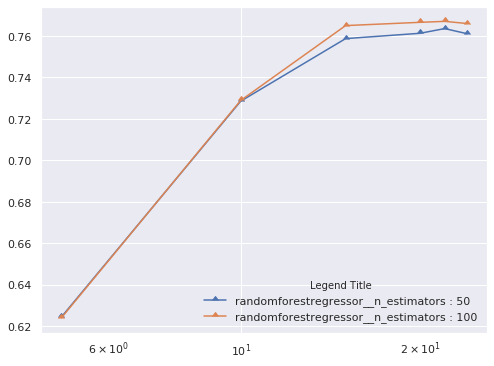

In [161]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


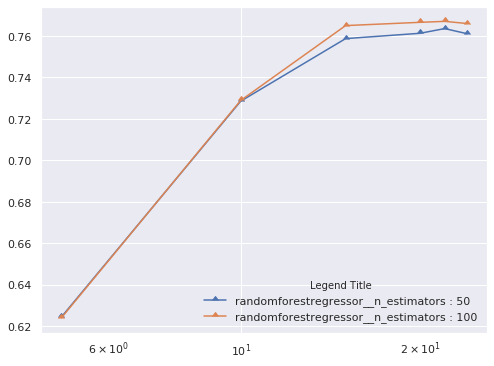

In [162]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


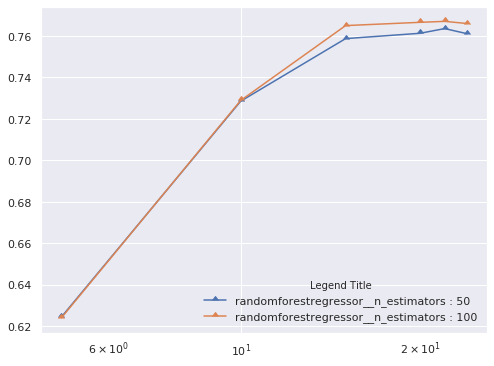

In [163]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [164]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [165]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
  [0.6520819442305585, -0.8519603321725377, -0.6365940379052029],
  [0.6361119245585076, -0.8716466411141109, -0.6225900260052712],
  [0.6668241309444778, -0.8341555958096161, -0.6338833117127363],
  [0.7670274399660982, -0.6975401884818021, -0.5024894142881048]]}

##### Consomation

In [166]:



params = {
            'randomforestregressor__max_depth': [5,10, 15, 20, 22, 24],
            'randomforestregressor__n_estimators': (50, 100),    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [167]:
grid.cv_results_

{'mean_fit_time': array([0.37194595, 0.86550407, 0.84790292, 1.12887292, 0.62613831,
        1.25032735, 0.71755557, 1.52977285, 0.81695361, 1.58142681,
        0.69266968, 1.40520034]),
 'std_fit_time': array([0.00524635, 0.08291517, 0.06718887, 0.142714  , 0.00716625,
        0.01235564, 0.03814595, 0.05688881, 0.05613898, 0.1497469 ,
        0.00770623, 0.06557851]),
 'mean_score_time': array([0.0119463 , 0.02076473, 0.02113085, 0.0195652 , 0.01312203,
        0.02153659, 0.01468592, 0.025492  , 0.01654978, 0.02501488,
        0.01409874, 0.02354107]),
 'std_score_time': array([0.00024202, 0.0027948 , 0.00485295, 0.00243239, 0.00023924,
        0.00041926, 0.00082908, 0.0010129 , 0.00121683, 0.00151735,
        0.00018416, 0.00156547]),
 'param_randomforestregressor__max_depth': masked_array(data=[5, 5, 10, 10, 15, 15, 20, 20, 22, 22, 24, 24],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_val

In [168]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [169]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.9233414 pour les paramètres randomforestregressor__max_depth : 20.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de RMSE est : -0.3113501 pour les paramètres randomforestregressor__max_depth : 20.0000000 et randomforestregressor__n_estimators : 100.0000000

Le meilleur score de MAE est : -0.1876132 pour les paramètres randomforestregressor__max_depth : 22.0000000 et randomforestregressor__n_estimators : 100.0000000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


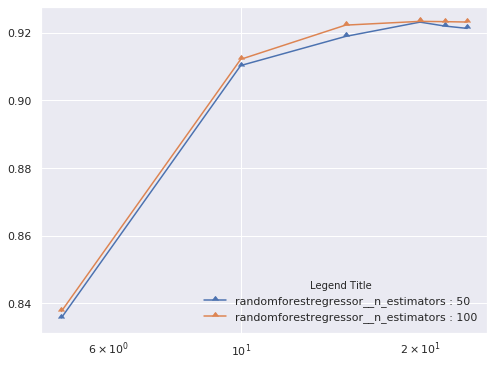

In [170]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


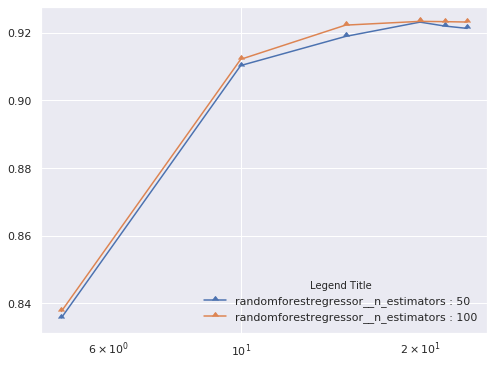

In [171]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


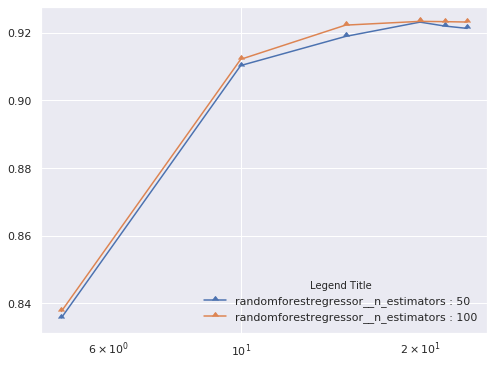

In [172]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [173]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [174]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197],
  [0.8110678027919672, -0.493811345915498, -0.2747881898197785],
  [0.8888414540279775, -0.37573070790117125, -0.2183112337530997],
  [0.8920072191502886, -0.3705332544678228, -0.21093548610554133],
  [0.8884913443806324, -0.37753420893191014, -0.23411440091183772],
  [0.9233413548330907, -0.3113501178258491, -0.18761321845346604]]}

#### Gradient Boost

In [175]:

from sklearn.ensemble import GradientBoostingRegressor
model_ML = GradientBoostingRegressor()

In [176]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'GradientBoostingRegressor'

In [177]:
model = make_pipeline(preprocessor,model_ML)
model.steps

[('columntransformer',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                    transformer_weights=None,
                    transformers=[('pipeline-1',
                                   Pipeline(memory=None,
                                            steps=[('standardscaler',
                                                    StandardScaler(copy=True,
                                                                   with_mean=True,
                                                                   with_std=True))],
                                            verbose=False),
                                   ['CouncilDistrictCode', 'YearBuilt',
                                    'sqrtNbBuild', 'sqrtNbFloor',
                                    'ENERGYSTARScore', 'logGFAPark',
                                    'logGFABuild']),
                                  (...
                                   ['UType_Hotel', 'UType_K-12 School',
     

In [178]:



params = {
            'gradientboostingregressor__n_estimators': (10, 50, 100, 200, 500),
            'gradientboostingregressor__learning_rate': np.logspace(-5, 0, 5),    
    
    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [179]:
grid.cv_results_

{'mean_fit_time': array([0.10759225, 0.3838582 , 0.70825086, 1.20474734, 2.36097693,
        0.04889641, 0.21009932, 0.41365676, 0.89485064, 2.42301645,
        0.05114861, 0.21321778, 0.41276402, 0.81434417, 2.15139513,
        0.05680561, 0.25342956, 0.51381607, 0.93246751, 2.21162415,
        0.05306864, 0.23394356, 0.43181863, 0.8216536 , 2.26219835]),
 'std_fit_time': array([2.08547719e-02, 3.73546752e-02, 5.98153286e-02, 8.68606648e-02,
        3.63193063e-01, 5.27942628e-04, 3.12315023e-03, 3.81059021e-03,
        6.62309196e-02, 1.84244671e-01, 8.75435103e-05, 1.12058598e-03,
        4.77865464e-03, 4.90889938e-03, 2.41343712e-01, 1.25299697e-03,
        1.16158986e-02, 3.37907901e-02, 4.22154639e-02, 1.28899531e-01,
        9.58343425e-04, 1.91797907e-02, 2.41370579e-02, 1.60996125e-02,
        1.45368357e-01]),
 'mean_score_time': array([0.01149087, 0.00905075, 0.00953512, 0.00897484, 0.00888157,
        0.00447397, 0.00480714, 0.00519218, 0.00650306, 0.00981622,
        0.00

In [180]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [181]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7041910 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de RMSE est : -0.7860962 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de MAE est : -0.5692054 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 1.0000000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


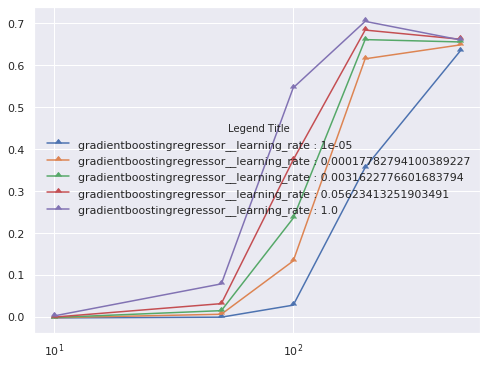

In [182]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


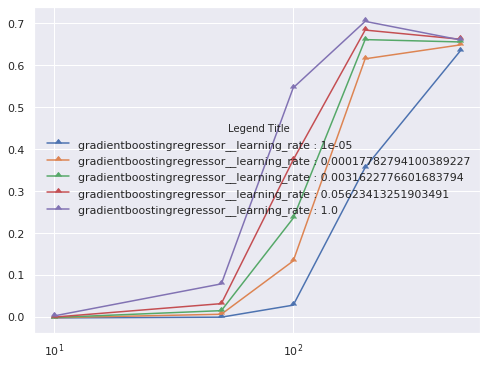

In [183]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


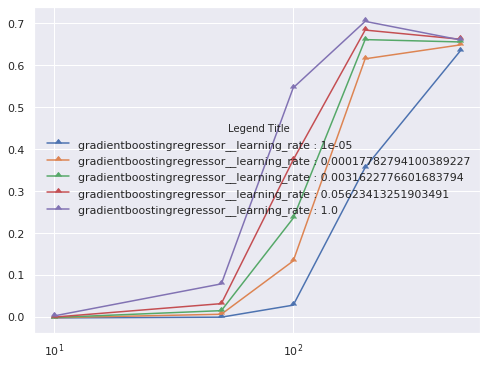

In [184]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [185]:
ERROR_EMI['Modèle'].append(model_name)
ERROR_EMI['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [186]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
  [0.6520819442305585, -0.8519603321725377, -0.6365940379052029],
  [0.6361119245585076, -0.8716466411141109, -0.6225900260052712],
  [0.6668241309444778, -0.8341555958096161, -0.6338833117127363],
  [0.7670274399660982, -0.6975401884818021, -0.5024894142881048],
  [0.7041909508850768, -0.7860962231372601, -0.5692053812579261]]}

##### Consomation

In [187]:



params = {
            'gradientboostingregressor__n_estimators': (10, 50, 100, 200, 500),
            'gradientboostingregressor__learning_rate': np.logspace(-5, 0, 5),    
    
    
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train,y_trainCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [188]:
grid.cv_results_

{'mean_fit_time': array([0.07011189, 0.30640483, 0.62610335, 1.41886468, 2.40238109,
        0.05184188, 0.21478691, 0.43416142, 0.83381295, 2.19255433,
        0.06213002, 0.24360342, 0.55898743, 1.06970549, 2.64564199,
        0.05938158, 0.31621194, 0.55845866, 1.07918754, 2.10294461,
        0.04677372, 0.20693669, 0.40392132, 0.80274034, 1.9922709 ]),
 'std_fit_time': array([6.40049578e-04, 4.21880773e-03, 4.07160907e-02, 1.16629548e-01,
        1.69919646e-01, 1.46281382e-03, 7.03742969e-04, 7.79835769e-03,
        4.91353384e-03, 1.40219770e-01, 1.55733724e-03, 7.46635492e-03,
        2.93404321e-02, 6.13556531e-02, 2.57833998e-01, 5.36630382e-03,
        2.75783834e-02, 7.67339725e-02, 1.66479869e-01, 1.05140784e-01,
        1.68689150e-04, 2.75264296e-03, 4.78025818e-03, 5.28266978e-03,
        4.89625982e-03]),
 'mean_score_time': array([0.00659113, 0.0069654 , 0.00800471, 0.01025071, 0.0096015 ,
        0.00474415, 0.00494509, 0.00602126, 0.00631781, 0.01012988,
        0.00

In [189]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [190]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.9130666 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de RMSE est : -0.3321288 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341

Le meilleur score de MAE est : -0.2092727 pour les paramètres gradientboostingregressor__n_estimators : 500.0000000 et gradientboostingregressor__learning_rate : 0.0562341


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


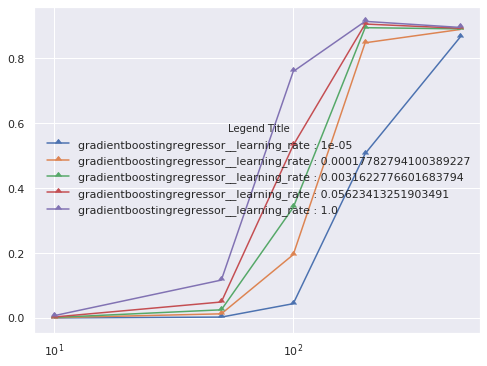

In [191]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


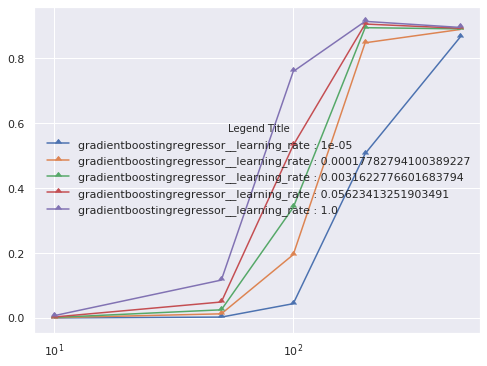

In [192]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


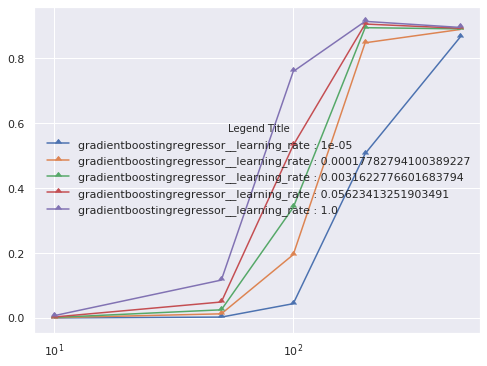

In [193]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [194]:
ERROR_CONSO['Modèle'].append(model_name)
ERROR_CONSO['Resuts'].append([resultR2, resultRMSE, resultMAE])

### Résultats

#### Emission

In [195]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
  [0.6520819442305585, -0.8519603321725377, -0.6365940379052029],
  [0.6361119245585076, -0.8716466411141109, -0.6225900260052712],
  [0.6668241309444778, -0.8341555958096161, -0.6338833117127363],
  [0.7670274399660982, -0.6975401884818021, -0.5024894142881048],
  [0.7041909508850768, -0.7860962231372601, -0.5692053812579261]]}

In [196]:
ERROR_EMI["Resuts"]

[[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
 [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
 [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
 [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
 [0.6520819442305585, -0.8519603321725377, -0.6365940379052029],
 [0.6361119245585076, -0.8716466411141109, -0.6225900260052712],
 [0.6668241309444778, -0.8341555958096161, -0.6338833117127363],
 [0.7670274399660982, -0.6975401884818021, -0.5024894142881048],
 [0.7041909508850768, -0.7860962231372601, -0.5692053812579261]]

In [197]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(ERROR_EMI["Resuts"][k][l])
        model.append(ERROR_EMI["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_EMI["type d'erreur"]*np.shape(ERROR_EMI["Modèle"])[0],
    "Résutats d'émission": result
}
d

{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 "Résutats d'émission": [0.5910554499948117,
  -0.9245211202959462,
  -0.7595229848038598,
  0.5911079426104384,
  -0.9244543520491171,
  -0.7594969428486891,
  0.6381827056219874,
  -0.86909106635

In [198]:
resultatEMI= pd.DataFrame(data=d)
resultatEMI

Modèle type d'erreur  Résutats d'émission
0            LinearRegression            R2             0.591055
1            LinearRegression          RMSE            -0.924521
2            LinearRegression           MAE            -0.759523
3                  ElasticNet            R2             0.591108
4                  ElasticNet          RMSE            -0.924454
5                  ElasticNet           MAE            -0.759497
6                      SVRlin            R2             0.638183
7                      SVRlin          RMSE            -0.869091
8                      SVRlin           MAE            -0.614981
9         KNeighborsRegressor            R2             0.578448
10        KNeighborsRegressor          RMSE            -0.938541
11        KNeighborsRegressor           MAE            -0.555037
12                KernelRidge            R2             0.652082
13                KernelRidge          RMSE            -0.851960
14                KernelRidge           MAE            -0.636594
15                        SVR            R2             0.636112
16                        SVR          RMSE            -0.871647
17                        SVR           MAE            -0.622590
18               MLPRegressor            R2             0.666824
19               MLPRegressor          RMSE            -0.834156
20               MLPRegressor           MAE            -0.633883
21      RandomForestRegressor            R2             0.767027
22      RandomForestRegressor          RMSE            -0.697540
23      RandomForestRegressor           MAE            -0.502489
24  GradientBoostingRegressor            R2             0.704191
25  GradientBoostingRegressor          RMSE            -0.786096
26  GradientBoostingRegressor           MAE            -0.569205

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

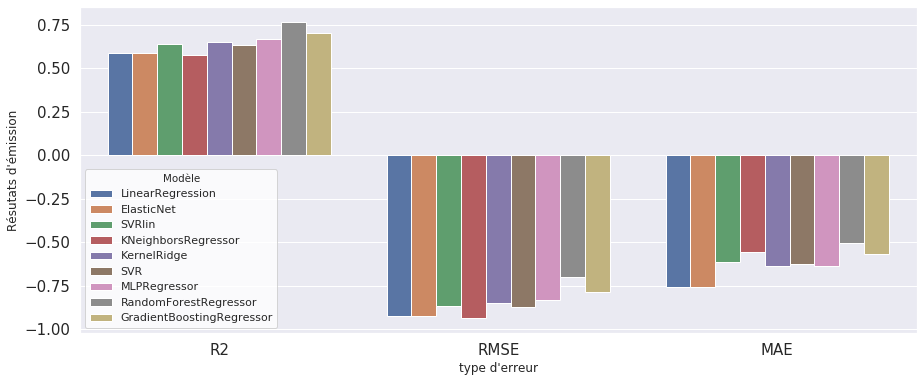

In [199]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatEMI
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [200]:
ERROR_EMI

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5910554499948117, -0.9245211202959462, -0.7595229848038598],
  [0.5911079426104384, -0.9244543520491171, -0.7594969428486891],
  [0.6381827056219874, -0.8690910663596915, -0.614980644251718],
  [0.5784484988915848, -0.9385408241893571, -0.5550372723511625],
  [0.6520819442305585, -0.8519603321725377, -0.6365940379052029],
  [0.6361119245585076, -0.8716466411141109, -0.6225900260052712],
  [0.6668241309444778, -0.8341555958096161, -0.6338833117127363],
  [0.7670274399660982, -0.6975401884818021, -0.5024894142881048],
  [0.7041909508850768, -0.7860962231372601, -0.5692053812579261]]}

#### Consomation

In [201]:
ERROR_CONSO

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8675014934207235, -0.41280040331493517, -0.26473926013752697],
  [0.8676242533174943, -0.41258472299660687, -0.26236361369982114],
  [0.8909603172988596, -0.3737816511238375, -0.21554082363777197],
  [0.8110678027919672, -0.493811345915498, -0.2747881898197785],
  [0.8888414540279775, -0.37573070790117125, -0.2183112337530997],
  [0.8920072191502886, -0.3705332544678228, -0.21093548610554133],
  [0.8884913443806324, -0.37753420893191014, -0.23411440091183772],
  [0.9233413548330907, -0.3113501178258491, -0.18761321845346604],
  [0.9130665638220311, -0.3321287913489343, -0.20927271838410982]]}

In [202]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(ERROR_CONSO["Resuts"][k][l])
        model.append(ERROR_CONSO["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_CONSO["type d'erreur"]*np.shape(ERROR_CONSO["Modèle"])[0],
    "Résutats de consomation": result
}
d


{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 'Résutats de consomation': [0.8675014934207235,
  -0.41280040331493517,
  -0.26473926013752697,
  0.8676242533174943,
  -0.41258472299660687,
  -0.26236361369982114,
  0.8909603172988596,
  -0.373

In [203]:
resultatCONSO= pd.DataFrame(data=d)
resultatCONSO

Modèle type d'erreur  Résutats de consomation
0            LinearRegression            R2                 0.867501
1            LinearRegression          RMSE                -0.412800
2            LinearRegression           MAE                -0.264739
3                  ElasticNet            R2                 0.867624
4                  ElasticNet          RMSE                -0.412585
5                  ElasticNet           MAE                -0.262364
6                      SVRlin            R2                 0.890960
7                      SVRlin          RMSE                -0.373782
8                      SVRlin           MAE                -0.215541
9         KNeighborsRegressor            R2                 0.811068
10        KNeighborsRegressor          RMSE                -0.493811
11        KNeighborsRegressor           MAE                -0.274788
12                KernelRidge            R2                 0.888841
13                KernelRidge          RMSE                -0.375731
14                KernelRidge           MAE                -0.218311
15                        SVR            R2                 0.892007
16                        SVR          RMSE                -0.370533
17                        SVR           MAE                -0.210935
18               MLPRegressor            R2                 0.888491
19               MLPRegressor          RMSE                -0.377534
20               MLPRegressor           MAE                -0.234114
21      RandomForestRegressor            R2                 0.923341
22      RandomForestRegressor          RMSE                -0.311350
23      RandomForestRegressor           MAE                -0.187613
24  GradientBoostingRegressor            R2                 0.913067
25  GradientBoostingRegressor          RMSE                -0.332129
26  GradientBoostingRegressor           MAE                -0.209273

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

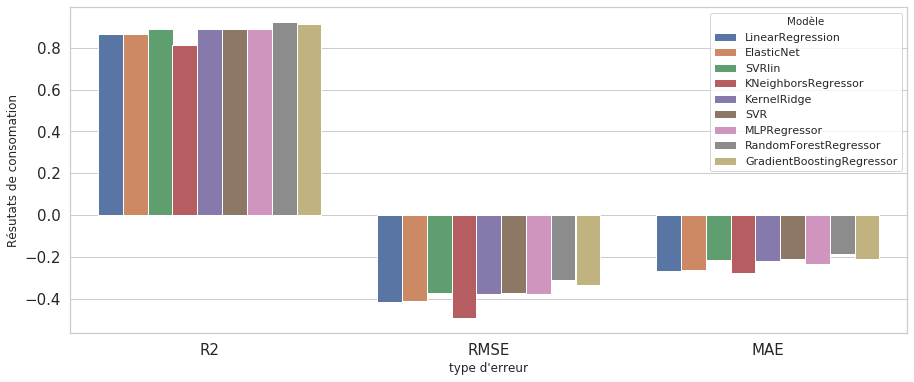

In [204]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatCONSO
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#### Save result Star

In [205]:
resultatEMI.to_csv('resultatEMI.csv', sep='\t', encoding='utf-8')
resultatCONSO.to_csv('resultatCONSO.csv', sep='\t', encoding='utf-8')


In [206]:
data

OSEBuildingID  CouncilDistrictCode  YearBuilt  NumberofBuildings  \
0                 1                    7       1927                1.0   
1                 2                    7       1996                1.0   
2                 3                    7       1969                1.0   
3                 5                    7       1926                1.0   
4                 8                    7       1980                1.0   
...             ...                  ...        ...                ...   
6512          50222                    2       1990                1.0   
6513          50223                    2       2004                1.0   
6514          50224                    7       1974                1.0   
6515          50225                    1       1989                1.0   
6516          50226                    2       1938                1.0   

      NumberofFloors  PropertyGFAParking  PropertyGFABuilding(s)  \
0               12.0                   1                   88434   
1               11.0               15064                   88502   
2               41.0                   1                  961990   
3               10.0                   1                   61320   
4               18.0               12460                  107430   
...              ...                 ...                     ...   
6512             1.0                   1                   12294   
6513             1.0                   1                   16000   
6514             1.0                   1                   13157   
6515             1.0                   1                   14101   
6516             1.0                   1                   18258   

      ENERGYSTARScore  GHGEmissions(MetricTonsCO2e)  ConsoSourceBrute  ...  \
0                65.0                        249.43      1.534330e+07  ...   
1                51.0                        263.51      1.981218e+07  ...   
2                18.0                       2061.48      2.334750e+08  ...   
3                 1.0                       1936.34      3.901792e+07  ...   
4                67.0                        507.70      2.743083e+07  ...   
...               ...                           ...               ...  ...   
6512             46.0                         20.94      1.987940e+06  ...   
6513              NaN                         32.17      1.827200e+06  ...   
6514              NaN                        223.54      9.799333e+06  ...   
6515              NaN                         22.11      1.484835e+06  ...   
6516              NaN                         41.27      2.114276e+06  ...   

      UType_Other  UType_Parking  UType_Restaurant  UType_Retail Store  \
0             0.0            0.0               0.0                 0.0   
1             0.0            2.0               1.0                 0.0   
2             0.0            2.0               0.0                 0.0   
3             0.0            0.0               0.0                 0.0   
4             0.0            2.0               0.0                 0.0   
...           ...            ...               ...                 ...   
6512          0.0            0.0               0.0                 0.0   
6513          0.0            0.0               0.0                 0.0   
6514          0.0            0.0               0.0                 0.0   
6515          0.0            0.0               0.0                 0.0   
6516          0.0            0.0               0.0                 0.0   

      BType_Multifamily HR (10+)  BType_Multifamily LR (1-4)  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
...                          ...                         ...   
6512                      

## étude sans ENERGY STAR

In [207]:
dataNoStar = data.drop(columns=["ENERGYSTARScore"]).dropna()

In [208]:
dataNoStar.shape

(6515, 30)

In [209]:
dataNoStar.columns

Index(['OSEBuildingID', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'GHGEmissions(MetricTonsCO2e)',
       'ConsoSourceBrute', 'logEMI', 'logCONSO', 'sqrtNbFloor', 'sqrtNbBuild',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

In [210]:
categorical_features = dataNoStar.columns[15 :].to_list()
categorical_features

['UType_Hotel',
 'UType_K-12 School',
 'UType_Multifamily Housing',
 'UType_Non-Refrigerated Warehouse',
 'UType_Office',
 'UType_Other',
 'UType_Parking',
 'UType_Restaurant',
 'UType_Retail Store',
 'BType_Multifamily HR (10+)',
 'BType_Multifamily LR (1-4)',
 'BType_Multifamily MR (5-9)',
 'BType_NonResidential',
 'BType_Nonresidential COS',
 'BType_SPS-District K-12']

### Isolation d'un set de données test X_test_noStar et y_test

In [211]:
from sklearn.model_selection import train_test_split

numerical_features = ['CouncilDistrictCode', 'YearBuilt','sqrtNbBuild', 
                      'sqrtNbFloor', 'logGFAPark', 'logGFABuild']

categorical_features = dataNoStar.columns[15:].to_list()


X = dataNoStar[numerical_features + categorical_features]
y = dataNoStar[[targetEMI] + [targetCONSO]]

X_train_noStar, X_test_noStar, Y_train_noStar, Y_test_noStar = train_test_split(X, y, test_size=0.2)
print(X_train_noStar.shape)
print(X_test_noStar.shape)
print(Y_train_noStar.shape)
print(Y_test_noStar.shape)

(5212, 21)
(1303, 21)
(5212, 2)
(1303, 2)


In [212]:
Y_train_noStarCONSO = Y_train_noStar[targetCONSO]
Y_train_noStarEMI = Y_train_noStar[targetEMI]

print(Y_train_noStarCONSO.shape)
print(Y_train_noStarEMI.shape)

(5212,)
(5212,)


In [213]:
X_train_noStar.to_csv('X_train_noStar.csv', sep='\t', encoding='utf-8')
Y_train_noStar.to_csv('Y_train_noStar.csv', sep='\t', encoding='utf-8')

X_test_noStar.to_csv('X_test_noStar.csv', sep='\t', encoding='utf-8')
Y_test_noStar.to_csv('Y_test_noStar.csv', sep='\t', encoding='utf-8')

### creation pipeline transformer

In [214]:
X_train_noStar.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

In [215]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(StandardScaler())
# categorical_pipeline = make_pipeline(FunctionTransformer())


In [216]:
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

### Evaluation des modèles avec validation croisées et comparaison avec eds approche de regression naives

#### Initialisation tableau ERROR

In [83]:
ERROR_EMI_noStar = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
ERROR_CONSO_noStar = {    
    'Modèle':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

#### modele linéaire 

In [218]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS


model_ML = LinearRegression()


In [219]:

import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'LinearRegression'

##### Emission

In [220]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train_noStar , Y_train_noStar)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [221]:
grid.cv_results_

{'mean_fit_time': array([0.0169404]),
 'std_fit_time': array([0.00101735]),
 'mean_score_time': array([0.00790076]),
 'std_score_time': array([0.00021606]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-1.12405372]),
 'split1_test_neg_root_mean_squared_error': array([-1.04675833]),
 'split2_test_neg_root_mean_squared_error': array([-1.03849063]),
 'split3_test_neg_root_mean_squared_error': array([-0.98886968]),
 'split4_test_neg_root_mean_squared_error': array([-1.04463043]),
 'mean_test_neg_root_mean_squared_error': array([-1.04856056]),
 'std_test_neg_root_mean_squared_error': array([0.04331816]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.47456422]),
 'split1_test_r2': array([0.49352975]),
 'split2_test_r2': array([0.54931533]),
 'split3_test_r2': array([0.54235532]),
 'split4_test_r2': array([0.4970818]),
 'mean_test_r2': array([0.51136929]),
 'std_test_r2': array([0.02924733]),
 'rank_test_r2': array([1], d

In [222]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [223]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [224]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376]]}

##### Consomation

In [225]:

model = make_pipeline(preprocessor,model_ML)
# model.fit(X_train_noStar , Y_train_noStar)

params = {}
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [226]:
grid.cv_results_

{'mean_fit_time': array([0.01878576]),
 'std_fit_time': array([0.00041596]),
 'mean_score_time': array([0.0085227]),
 'std_score_time': array([0.00024158]),
 'params': [{}],
 'split0_test_neg_root_mean_squared_error': array([-0.62681413]),
 'split1_test_neg_root_mean_squared_error': array([-0.58393594]),
 'split2_test_neg_root_mean_squared_error': array([-0.59096093]),
 'split3_test_neg_root_mean_squared_error': array([-0.5881661]),
 'split4_test_neg_root_mean_squared_error': array([-0.61039253]),
 'mean_test_neg_root_mean_squared_error': array([-0.60005392]),
 'std_test_neg_root_mean_squared_error': array([0.01616656]),
 'rank_test_neg_root_mean_squared_error': array([1], dtype=int32),
 'split0_test_r2': array([0.72281345]),
 'split1_test_r2': array([0.73137127]),
 'split2_test_r2': array([0.77216079]),
 'split3_test_r2': array([0.7658638]),
 'split4_test_r2': array([0.73122404]),
 'mean_test_r2': array([0.74468667]),
 'std_test_r2': array([0.02020039]),
 'rank_test_r2': array([1], dt

In [227]:
resultR2 = grid.cv_results_["mean_test_r2"][0]
resultRMSE =  grid.cv_results_["mean_test_neg_root_mean_squared_error"][0]
resultMAE =  grid.cv_results_["mean_test_neg_mean_absolute_error"][0]

In [228]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [229]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179]]}

#### modele linaire avec Elastic Net

In [230]:
from sklearn.linear_model import ElasticNet

model_ML = ElasticNet()


In [231]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'ElasticNet'

In [232]:
model = make_pipeline(preprocessor,model_ML)
model

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [233]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2186.146584105162, tolerance: 0.9241154970187556
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2275.038530834299, tolerance: 0.949151096950824
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2283.544975149291, tolerance: 0.9252935487352296
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [234]:
paramList = list(params.keys())


In [235]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.5113924 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000

Le meilleur score de RMSE est : -1.0485372 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000

Le meilleur score de MAE est : -0.8366842 pour les paramètres alpha 0.0010000 et l1_ratio 0.0000000


In [236]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


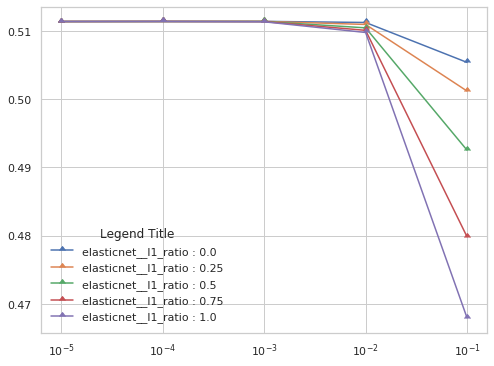

In [237]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


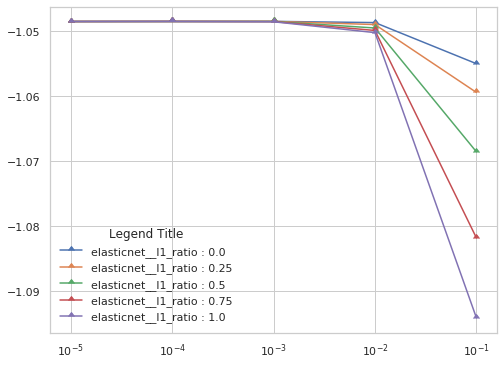

In [238]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


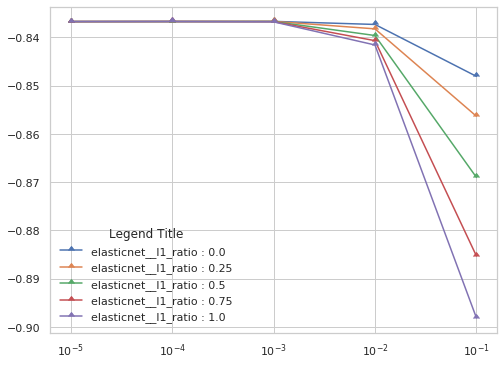

In [239]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [240]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [241]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376],
  [0.5113924302869325, -1.0485371949116327, -0.8366842201352647]]}

##### Consomation

In [242]:


params = {
    "elasticnet__alpha" : np.logspace(-5, -1, 5),
    "elasticnet__l1_ratio" : np.linspace(0, 1.0, num=5),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.8221165072342, tolerance: 0.5913822894281122
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 754.323304513706, tolerance: 0.6064555647274779
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 749.6669309282198, tolerance: 0.5793465817238739
  positive)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [243]:
paramList = list(params.keys())


In [244]:

result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultR2 = bestScore

result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultRMSE = bestScore


result = grid.cv_results_['mean_test_neg_mean_absolute_error']

bestScore = np.amax(result)

resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]

print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres alpha {:3.7f} et l1_ratio {:3.7f}"
      .format(bestScore,bestParam[paramList[0]],bestParam[paramList[1]] )  )

resultMAE = bestScore



Le meilleur score de R2 est : 0.7446922 pour les paramètres alpha 0.0001000 et l1_ratio 1.0000000

Le meilleur score de RMSE est : -0.6000462 pour les paramètres alpha 0.0001000 et l1_ratio 1.0000000

Le meilleur score de MAE est : -0.4042734 pour les paramètres alpha 0.0100000 et l1_ratio 0.5000000


In [245]:
params[paramList[1]]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


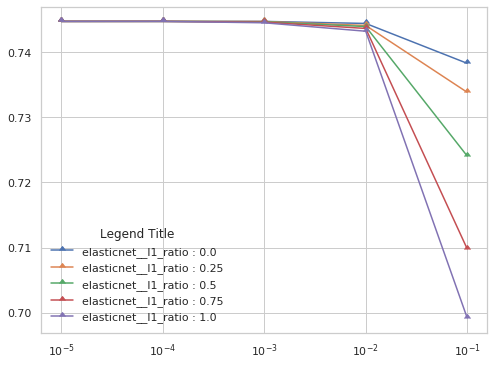

In [246]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


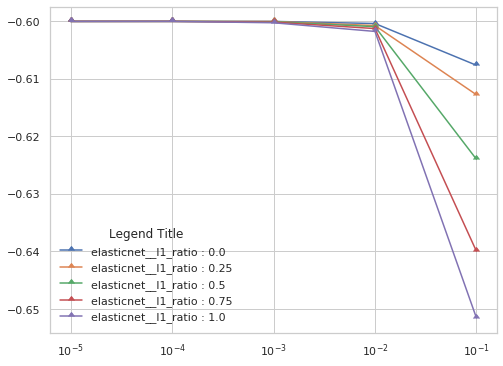

In [247]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


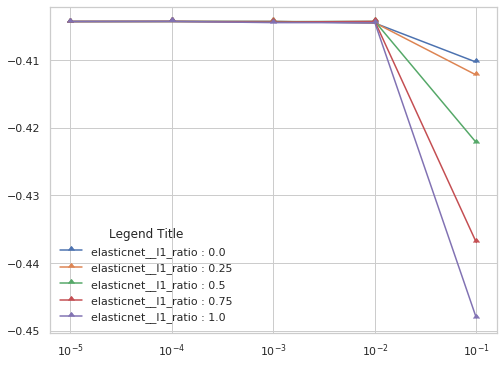

In [248]:
fig, ax = plt.subplots(1, figsize=(8, 6))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

ax.set_xscale('log')
plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [249]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [250]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression', 'ElasticNet'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179],
  [0.744692165604547, -0.6000462056856694, -0.40427336441391937]]}

#### modele linaire avec SVR

In [251]:
from sklearn.svm import SVR
model_ML = SVR()

In [252]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0) + "lin"
model_name

'SVRlin'

In [253]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [254]:

params = {
    "svr__C" : np.logspace(-1, 2, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [255]:
grid.cv_results_

{'mean_fit_time': array([1.73373327, 1.77384019, 2.08161302, 2.92046099, 5.57253361]),
 'std_fit_time': array([0.03237637, 0.01564181, 0.07955393, 0.21158155, 0.16975566]),
 'mean_score_time': array([0.2429275 , 0.2304297 , 0.23010478, 0.20958662, 0.1593286 ]),
 'std_score_time': array([0.00675565, 0.0048335 , 0.01523818, 0.02571243, 0.00174476]),
 'param_svr__C': masked_array(data=[0.1, 0.5623413251903491, 3.1622776601683795,
                    17.78279410038923, 100.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.1},
  {'svr__C': 0.5623413251903491},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 17.78279410038923},
  {'svr__C': 100.0}],
 'split0_test_neg_root_mean_squared_error': array([-1.12678693, -1.06858378, -1.03438457, -1.01572176, -1.0387315 ]),
 'split1_test_neg_root_mean_squared_error': array([-1.0242462 , -0.98964401, -0.97376288, -0.96166909, -0.98278141]),
 'split2_test_neg_root_mea

In [256]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [257]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5799092 pour les paramètres svr__C : 17.7827941

Le meilleur score de RMSE est : -0.9716244 pour les paramètres svr__C : 17.7827941

Le meilleur score de MAE est : -0.6911700 pour les paramètres svr__C : 17.7827941


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


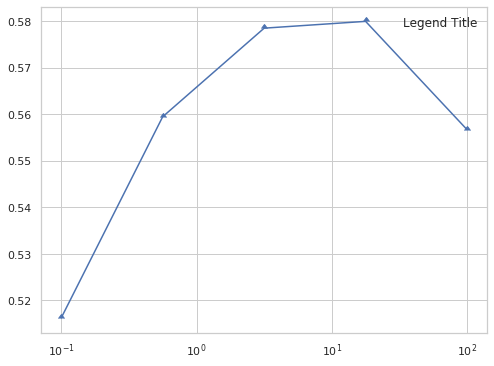

In [258]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


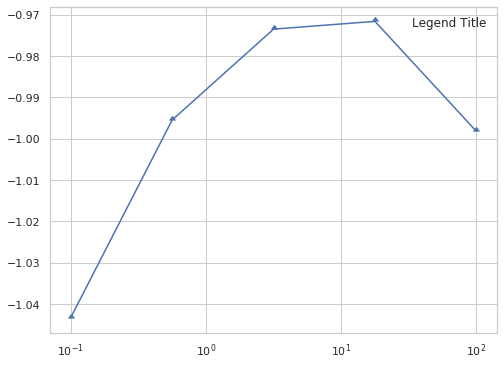

In [259]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


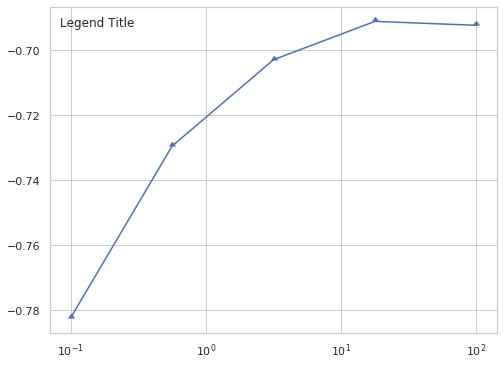

In [260]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [261]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [262]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376],
  [0.5113924302869325, -1.0485371949116327, -0.8366842201352647],
  [0.579909188095443, -0.971624379366445, -0.691170005069318]]}

##### Consomation

In [263]:

params = {
    "svr__C" : np.logspace(-2, 3, 5)
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [264]:
grid.cv_results_

{'mean_fit_time': array([ 1.57094908,  1.15500789,  1.44378109,  4.70331168, 48.89644175]),
 'std_fit_time': array([0.11286031, 0.00538582, 0.00655958, 0.0874562 , 4.73059416]),
 'mean_score_time': array([0.21101007, 0.14930172, 0.14332666, 0.1395679 , 0.14648929]),
 'std_score_time': array([0.02053224, 0.00094256, 0.00082179, 0.00088535, 0.01900802]),
 'param_svr__C': masked_array(data=[0.01, 0.1778279410038923, 3.1622776601683795,
                    56.23413251903491, 1000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svr__C': 0.01},
  {'svr__C': 0.1778279410038923},
  {'svr__C': 3.1622776601683795},
  {'svr__C': 56.23413251903491},
  {'svr__C': 1000.0}],
 'split0_test_neg_root_mean_squared_error': array([-0.81815224, -0.6348291 , -0.58085045, -0.56855386, -0.65625773]),
 'split1_test_neg_root_mean_squared_error': array([-0.77348562, -0.60590537, -0.56518392, -0.58192702, -0.70175862]),
 'split2_test_neg

In [265]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [266]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7753849 pour les paramètres svr__C : 3.1622777

Le meilleur score de RMSE est : -0.5618068 pour les paramètres svr__C : 3.1622777

Le meilleur score de MAE est : -0.3576734 pour les paramètres svr__C : 3.1622777


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


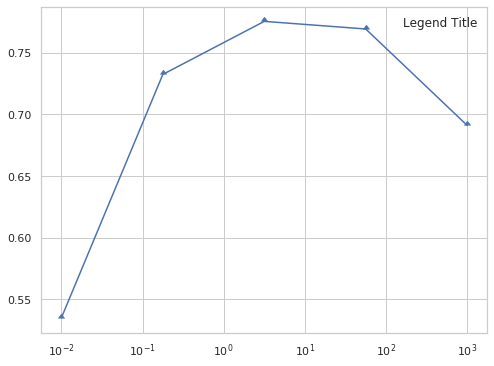

In [267]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


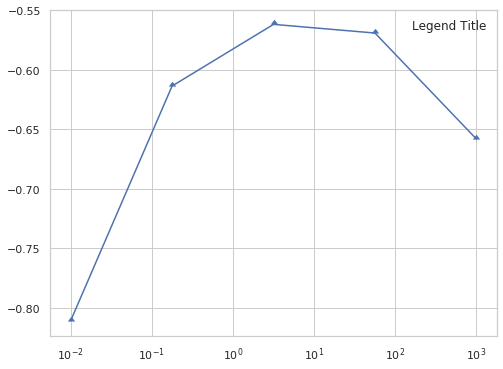

In [268]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


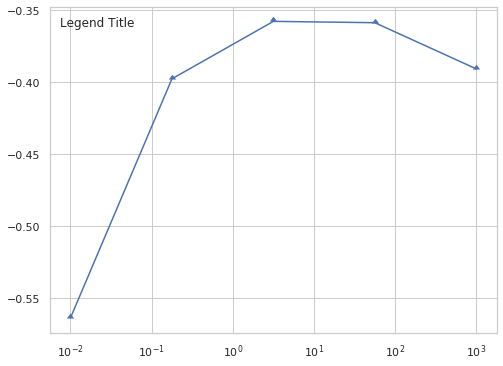

In [269]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [270]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [271]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179],
  [0.744692165604547, -0.6000462056856694, -0.40427336441391937],
  [0.775384867469244, -0.5618067715406535, -0.3576733817762874]]}

#### modele KNN 

In [272]:
from sklearn.neighbors import KNeighborsRegressor
model_ML = KNeighborsRegressor()

In [273]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KNeighborsRegressor'

In [274]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [275]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,40),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [276]:
grid.cv_results_

{'mean_fit_time': array([0.05215487, 0.04287047, 0.04646797, 0.06019502, 0.05598388,
        0.05218816, 0.06277623, 0.05956988, 0.06464934, 0.05189261,
        0.04995294, 0.03967166, 0.03768678, 0.03874459, 0.03658028,
        0.05797739, 0.04514494, 0.06453395, 0.04783568, 0.04231286,
        0.04131355, 0.0361124 , 0.03497486, 0.03505578, 0.03896379,
        0.0392467 , 0.03583384, 0.03466191, 0.03542376, 0.03510079,
        0.0371089 , 0.04001913, 0.04056978, 0.04058309, 0.04052453,
        0.04065509, 0.04813752, 0.04062953, 0.05037541]),
 'std_fit_time': array([0.00712053, 0.00166209, 0.00261499, 0.00993763, 0.00516742,
        0.00656686, 0.00971953, 0.00504704, 0.00562699, 0.00931697,
        0.00337255, 0.00066137, 0.00184815, 0.00266798, 0.00124162,
        0.01012846, 0.00210238, 0.02612409, 0.00412876, 0.00194179,
        0.00544959, 0.00126961, 0.00097404, 0.00159554, 0.00484034,
        0.0013844 , 0.0013272 , 0.00126577, 0.00094498, 0.00173603,
        0.00256639, 0.002

In [277]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [278]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5328721 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de RMSE est : -1.0246851 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de MAE est : -0.5848875 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


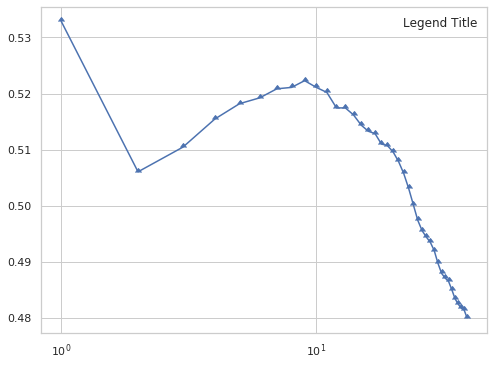

In [279]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


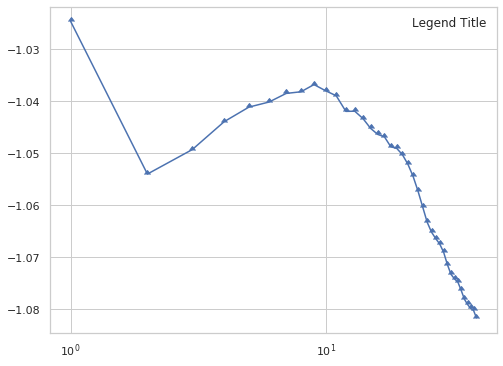

In [280]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


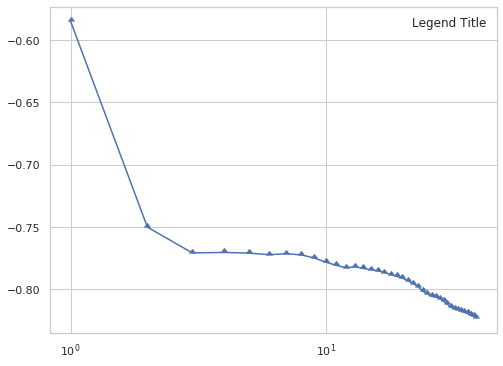

In [281]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [282]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [283]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376],
  [0.5113924302869325, -1.0485371949116327, -0.8366842201352647],
  [0.579909188095443, -0.971624379366445, -0.691170005069318],
  [0.5328721175777332, -1.0246850590633096, -0.5848874946415299]]}

##### Consomation

In [284]:

params = {
    "kneighborsregressor__n_neighbors" : range(1,20),
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [285]:
grid.cv_results_

{'mean_fit_time': array([0.0508935 , 0.05294404, 0.05610013, 0.05057602, 0.04973979,
        0.05340219, 0.05306864, 0.05015345, 0.04171634, 0.03981204,
        0.04005318, 0.04065313, 0.04455647, 0.04240365, 0.04396858,
        0.04499531, 0.04681258, 0.04296646, 0.04031963]),
 'std_fit_time': array([0.00282754, 0.00279721, 0.00256339, 0.00209104, 0.00392082,
        0.00345167, 0.00168881, 0.00175323, 0.00102713, 0.00124738,
        0.00239697, 0.00157649, 0.00259848, 0.00139383, 0.00353982,
        0.00161671, 0.00224175, 0.00118253, 0.00100812]),
 'mean_score_time': array([0.12838507, 0.14844618, 0.1667644 , 0.15210843, 0.15527167,
        0.16950302, 0.16986465, 0.16140647, 0.14016943, 0.13587532,
        0.13839989, 0.14311986, 0.1523231 , 0.14952278, 0.15989394,
        0.16966143, 0.16380591, 0.15483408, 0.15152125]),
 'std_score_time': array([0.00733791, 0.00827042, 0.00560537, 0.00751395, 0.00973208,
        0.00687082, 0.00703936, 0.00789139, 0.00296365, 0.00230961,
        

In [286]:
paramList = list(params.keys())
np.shape(paramList)[0]

1

In [287]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7304006 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de RMSE est : -0.6159293 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000

Le meilleur score de MAE est : -0.3307281 pour les paramètres kneighborsregressor__n_neighbors : 1.0000000


No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


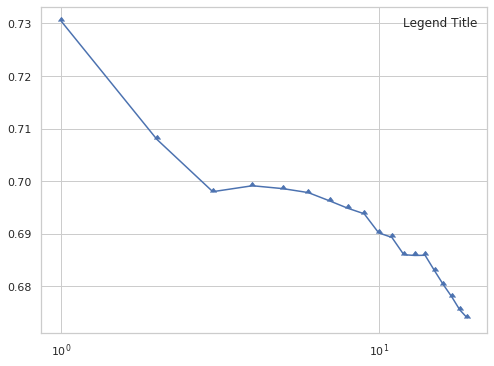

In [288]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


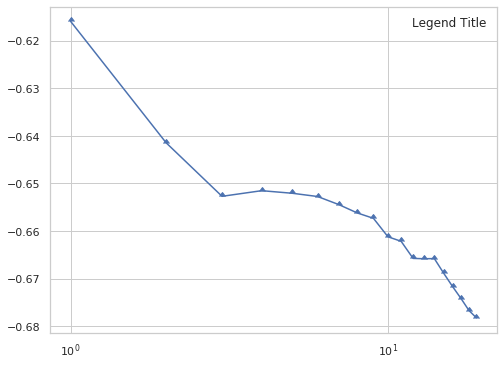

In [289]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

No handles with labels found to put in legend.
/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


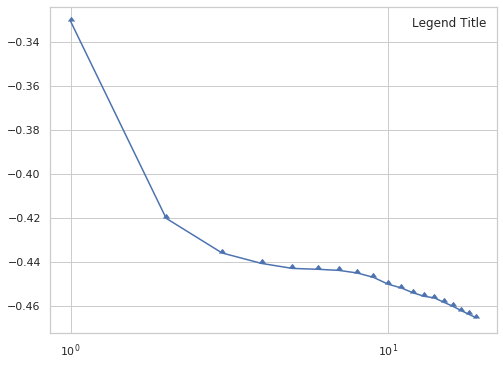

In [290]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [291]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [292]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression', 'ElasticNet', 'SVRlin', 'KNeighborsRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179],
  [0.744692165604547, -0.6000462056856694, -0.40427336441391937],
  [0.775384867469244, -0.5618067715406535, -0.3576733817762874],
  [0.730400565681392, -0.6159292958088751, -0.33072808660704756]]}

#### modele non linéaire La régression ridge à noyau

In [293]:
from sklearn import kernel_ridge
model_ML = kernel_ridge.KernelRidge()
       

In [294]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'KernelRidge'

In [295]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [296]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [297]:
grid.cv_results_

{'mean_fit_time': array([1.96546822, 1.92359266, 1.37996402, 1.02127385, 0.99810224,
        0.98586421, 0.98705492, 0.98365726, 1.08530955, 1.32429724,
        1.06457181, 0.98150249, 0.97820902, 0.97782331, 0.97678313,
        0.97565446, 0.97481942, 0.97658076, 0.97617474, 0.9799665 ,
        0.97519484, 0.97533922, 1.00829983, 0.97307811, 1.00700731]),
 'std_fit_time': array([0.13395289, 0.27240744, 0.12637371, 0.05690827, 0.02473496,
        0.02020212, 0.02160192, 0.01477239, 0.07997973, 0.25725992,
        0.17044397, 0.01765816, 0.01620814, 0.01584017, 0.01458203,
        0.01594012, 0.01553945, 0.01414619, 0.01375455, 0.01452131,
        0.01660376, 0.01376055, 0.05164594, 0.01578742, 0.05108335]),
 'mean_score_time': array([0.1404294 , 0.11990595, 0.10524187, 0.08255711, 0.08491378,
        0.08092508, 0.08116269, 0.08189964, 0.08948026, 0.10322356,
        0.08235216, 0.08256969, 0.08172669, 0.08193388, 0.08184004,
        0.08156247, 0.08125973, 0.08162594, 0.08166275, 0.08

In [298]:
grid.cv_results_

{'mean_fit_time': array([1.96546822, 1.92359266, 1.37996402, 1.02127385, 0.99810224,
        0.98586421, 0.98705492, 0.98365726, 1.08530955, 1.32429724,
        1.06457181, 0.98150249, 0.97820902, 0.97782331, 0.97678313,
        0.97565446, 0.97481942, 0.97658076, 0.97617474, 0.9799665 ,
        0.97519484, 0.97533922, 1.00829983, 0.97307811, 1.00700731]),
 'std_fit_time': array([0.13395289, 0.27240744, 0.12637371, 0.05690827, 0.02473496,
        0.02020212, 0.02160192, 0.01477239, 0.07997973, 0.25725992,
        0.17044397, 0.01765816, 0.01620814, 0.01584017, 0.01458203,
        0.01594012, 0.01553945, 0.01414619, 0.01375455, 0.01452131,
        0.01660376, 0.01376055, 0.05164594, 0.01578742, 0.05108335]),
 'mean_score_time': array([0.1404294 , 0.11990595, 0.10524187, 0.08255711, 0.08491378,
        0.08092508, 0.08116269, 0.08189964, 0.08948026, 0.10322356,
        0.08235216, 0.08256969, 0.08172669, 0.08193388, 0.08184004,
        0.08156247, 0.08125973, 0.08162594, 0.08166275, 0.08

In [299]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [300]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5820807 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de RMSE est : -0.9686579 pour les paramètres kernelridge__alpha : 0.0562341 et kernelridge__gamma : 0.0316228

Le meilleur score de MAE est : -0.7143522 pour les paramètres kernelridge__alpha : 0.0031623 et kernelridge__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


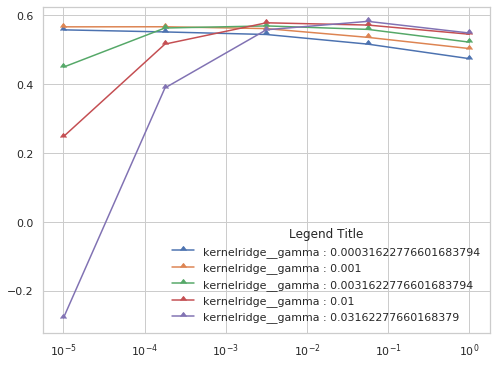

In [301]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


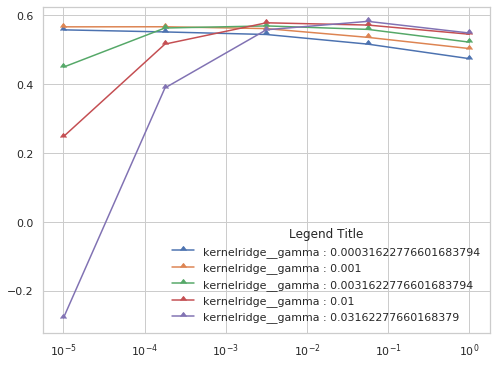

In [302]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


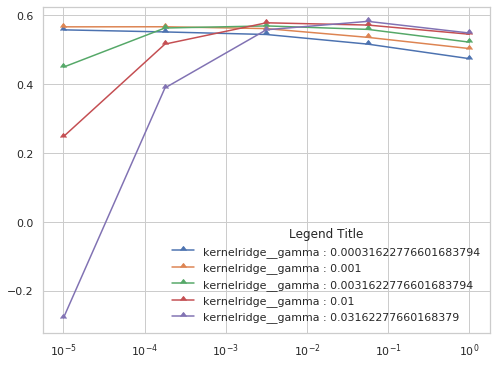

In [303]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [304]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [305]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376],
  [0.5113924302869325, -1.0485371949116327, -0.8366842201352647],
  [0.579909188095443, -0.971624379366445, -0.691170005069318],
  [0.5328721175777332, -1.0246850590633096, -0.5848874946415299],
  [0.582080709177899, -0.9686578890292472, -0.7143521785356891]]}

##### Consomation 

In [306]:



params = {
    "kernelridge__alpha" : np.logspace(-5, 0, 5),
    "kernelridge__gamma" : np.logspace(-3.5, -1.5, 5),
    "kernelridge__kernel" : ['rbf'],
}


grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [307]:
grid.cv_results_

{'mean_fit_time': array([1.16406388, 1.13839364, 0.98403215, 0.99973192, 0.97809157,
        1.0183229 , 0.97462063, 0.98224311, 0.97972412, 0.97612143,
        0.9779357 , 0.97609334, 0.97527785, 0.97620854, 0.9794713 ,
        0.9766736 , 0.97748876, 0.97795663, 0.97728119, 0.98010135,
        0.97870193, 1.02947941, 1.04067597, 1.01547174, 1.11924024]),
 'std_fit_time': array([0.14633138, 0.08177634, 0.02667036, 0.01913981, 0.01843411,
        0.05637143, 0.01462776, 0.01582126, 0.01505703, 0.01546903,
        0.017473  , 0.01589063, 0.0156988 , 0.01543284, 0.01467245,
        0.01626365, 0.01375114, 0.01444129, 0.01462151, 0.01659406,
        0.01542364, 0.09890113, 0.05603061, 0.05841342, 0.12967687]),
 'mean_score_time': array([0.08956079, 0.08526397, 0.08246384, 0.09860072, 0.08284764,
        0.09145093, 0.08348923, 0.08218594, 0.08239584, 0.08117099,
        0.08125777, 0.08179889, 0.0816967 , 0.08171382, 0.08242044,
        0.08143983, 0.08240542, 0.08176894, 0.0813396 , 0.08

In [308]:
grid.cv_results_

{'mean_fit_time': array([1.16406388, 1.13839364, 0.98403215, 0.99973192, 0.97809157,
        1.0183229 , 0.97462063, 0.98224311, 0.97972412, 0.97612143,
        0.9779357 , 0.97609334, 0.97527785, 0.97620854, 0.9794713 ,
        0.9766736 , 0.97748876, 0.97795663, 0.97728119, 0.98010135,
        0.97870193, 1.02947941, 1.04067597, 1.01547174, 1.11924024]),
 'std_fit_time': array([0.14633138, 0.08177634, 0.02667036, 0.01913981, 0.01843411,
        0.05637143, 0.01462776, 0.01582126, 0.01505703, 0.01546903,
        0.017473  , 0.01589063, 0.0156988 , 0.01543284, 0.01467245,
        0.01626365, 0.01375114, 0.01444129, 0.01462151, 0.01659406,
        0.01542364, 0.09890113, 0.05603061, 0.05841342, 0.12967687]),
 'mean_score_time': array([0.08956079, 0.08526397, 0.08246384, 0.09860072, 0.08284764,
        0.09145093, 0.08348923, 0.08218594, 0.08239584, 0.08117099,
        0.08125777, 0.08179889, 0.0816967 , 0.08171382, 0.08242044,
        0.08143983, 0.08240542, 0.08176894, 0.0813396 , 0.08

In [309]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [310]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7696204 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0010000

Le meilleur score de RMSE est : -0.5688938 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0010000

Le meilleur score de MAE est : -0.3692978 pour les paramètres kernelridge__alpha : 0.0000100 et kernelridge__gamma : 0.0010000


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


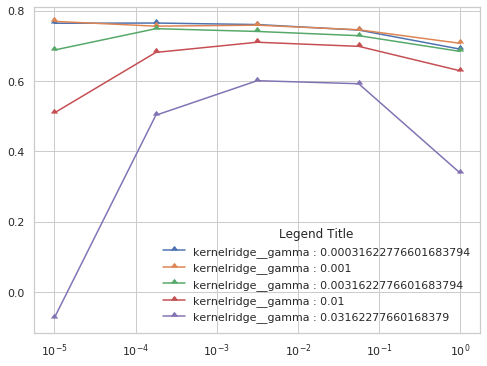

In [311]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


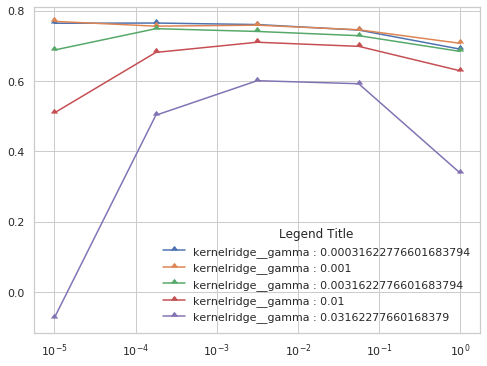

In [312]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


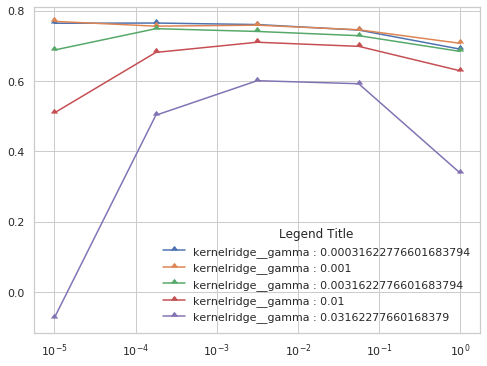

In [313]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [314]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [315]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179],
  [0.744692165604547, -0.6000462056856694, -0.40427336441391937],
  [0.775384867469244, -0.5618067715406535, -0.3576733817762874],
  [0.730400565681392, -0.6159292958088751, -0.33072808660704756],
  [0.7696204391688981, -0.568893794491012, -0.36929778296261934]]}

#### modele non linéaire : SVR

In [316]:
from sklearn.svm import SVR
model_ML = SVR()
                                     


In [317]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'SVR'

In [318]:
model = make_pipeline(preprocessor,model_ML)
model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt', 'sqrtNbBuild',
                

In [319]:



params = {
    "svr__C" : np.logspace(-1, 2, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 3)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [320]:
grid.cv_results_

{'mean_fit_time': array([2.03122296, 1.36336637, 1.30350003, 1.34884052, 1.33918266,
        1.32552137, 1.38345366, 1.39888105, 1.48691292, 1.39411159,
        1.49736786, 2.08002276, 1.51540203, 2.26569786, 5.44151587]),
 'std_fit_time': array([0.3145235 , 0.04756882, 0.00899053, 0.0074385 , 0.03474661,
        0.01108135, 0.09554396, 0.02499786, 0.01774225, 0.02158197,
        0.01886845, 0.0176774 , 0.01683518, 0.10300361, 0.40132591]),
 'mean_score_time': array([0.30162721, 0.19074726, 0.17985826, 0.19673376, 0.18189645,
        0.17796712, 0.1889957 , 0.18127279, 0.16960135, 0.17993646,
        0.1742013 , 0.1672914 , 0.17986536, 0.18015475, 0.18424053]),
 'std_score_time': array([0.0818197 , 0.01160655, 0.00083683, 0.01581581, 0.00070088,
        0.00046019, 0.01319609, 0.00018284, 0.00102459, 0.00256271,
        0.00281905, 0.00064532, 0.0024929 , 0.0083654 , 0.0141157 ]),
 'param_svr__C': masked_array(data=[0.1, 0.1, 0.1, 0.5623413251903491, 0.5623413251903491,
               

In [321]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [322]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5765815 pour les paramètres svr__C : 17.7827941 et svr__gamma : 0.0316228

Le meilleur score de RMSE est : -0.9755690 pour les paramètres svr__C : 17.7827941 et svr__gamma : 0.0316228

Le meilleur score de MAE est : -0.6956610 pour les paramètres svr__C : 100.0000000 et svr__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


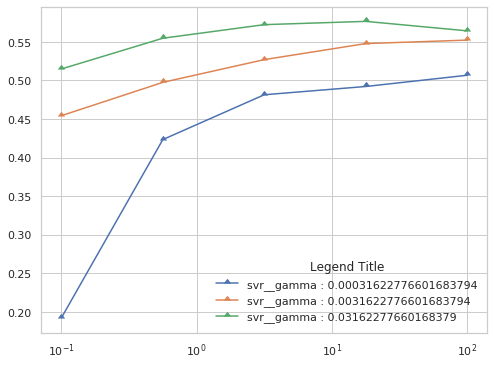

In [323]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


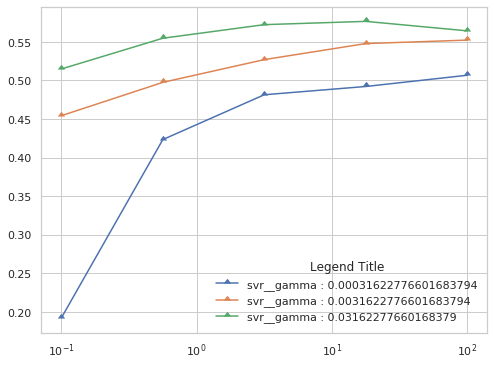

In [324]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


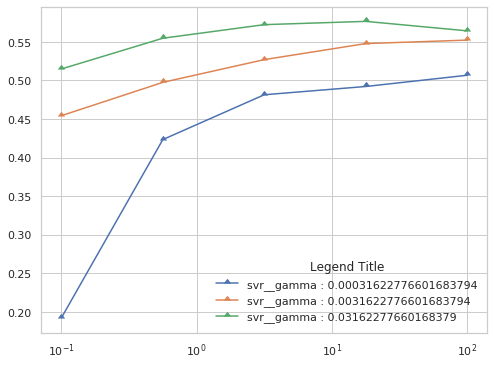

In [325]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [326]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [327]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376],
  [0.5113924302869325, -1.0485371949116327, -0.8366842201352647],
  [0.579909188095443, -0.971624379366445, -0.691170005069318],
  [0.5328721175777332, -1.0246850590633096, -0.5848874946415299],
  [0.582080709177899, -0.9686578890292472, -0.7143521785356891],
  [0.5765814969491694, -0.9755689528972, -0.6956609737599043]]}

##### Consomation

In [328]:



params = {
    "svr__C" : np.logspace(-2, 3, 5),
    "svr__gamma" : np.logspace(-3.5, -1.5, 5)
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [329]:
grid.cv_results_

{'mean_fit_time': array([ 1.60570989,  1.34539089,  1.3222568 ,  1.26537061,  1.22965198,
         1.28412433,  1.23584104,  1.34027605,  1.18845096,  1.15899839,
         1.15970116,  1.17199717,  1.23111429,  1.28392005,  1.37474737,
         1.3460073 ,  1.4951241 ,  1.93977394,  2.80923462,  4.15198483,
         2.65751548,  5.12820692, 11.25716243, 23.74788747, 41.97155709]),
 'std_fit_time': array([1.79709648e-01, 3.08182013e-03, 1.28683210e-03, 8.44670353e-03,
        5.20396227e-03, 5.20660699e-03, 6.17459182e-02, 1.39937085e-01,
        4.94489173e-02, 5.19655541e-03, 7.66392131e-03, 5.64705968e-03,
        8.37356599e-02, 2.98017590e-02, 1.97356547e-02, 2.88575776e-02,
        2.43062229e-02, 5.52990718e-02, 9.64492842e-02, 9.76270812e-02,
        1.19131647e-01, 7.77446323e-02, 6.57879447e-01, 1.84197335e+00,
        3.95070726e+00]),
 'mean_score_time': array([0.21017599, 0.18337221, 0.18016634, 0.17176919, 0.16662126,
        0.1738874 , 0.17072349, 0.17475681, 0.15843244,

In [330]:
paramList = list(params.keys())
np.shape(paramList)[0]

2

In [331]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7754309 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0316228

Le meilleur score de RMSE est : -0.5616896 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0316228

Le meilleur score de MAE est : -0.3561612 pour les paramètres svr__C : 56.2341325 et svr__gamma : 0.0316228


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


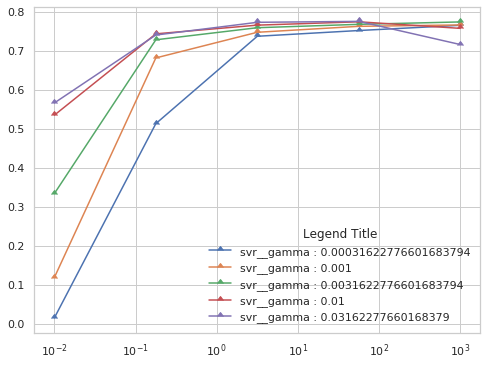

In [332]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


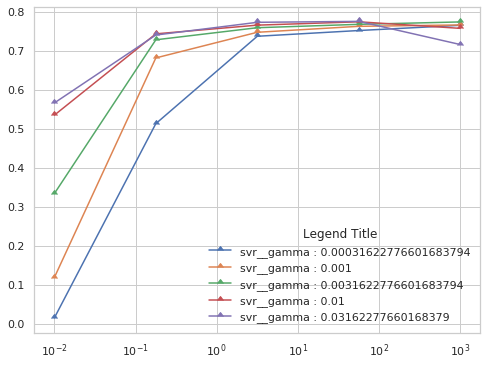

In [333]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


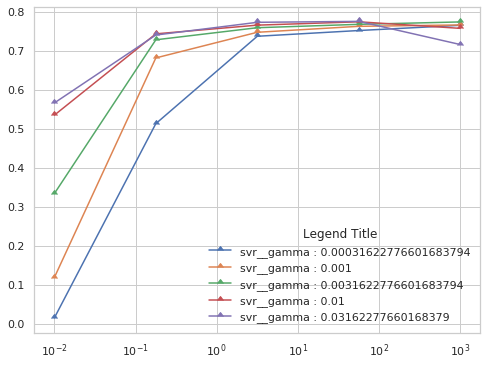

In [334]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [335]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [336]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179],
  [0.744692165604547, -0.6000462056856694, -0.40427336441391937],
  [0.775384867469244, -0.5618067715406535, -0.3576733817762874],
  [0.730400565681392, -0.6159292958088751, -0.33072808660704756],
  [0.7696204391688981, -0.568893794491012, -0.36929778296261934],
  [0.7754308714572932, -0.5616895866966419, -0.3561611872739751]]}

#### modele non linéaire : réseau de neurones

In [337]:

from sklearn.neural_network import MLPRegressor


model_ML = MLPRegressor()

In [338]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'MLPRegressor'

In [339]:

model = make_pipeline(preprocessor,model_ML)
print(model.steps)


[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark',
                                  'logGFABuild']),
                                ('pipeline-2',
                                 Pipel...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  'U

In [340]:



params = {
    'mlpregressor__max_iter': [50,80, 100,150,200,300],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['logistic'],
    'mlpregressor__solver': ["lbfgs"],
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [341]:
grid.cv_results_

{'mean_fit_time': array([0.32536654, 0.68769813, 0.68558054, 0.69901781, 0.91623707,
        1.37360086, 0.45998068, 0.72071319, 0.90056629, 1.3416163 ,
        1.82107501, 2.76125484, 0.73593688, 1.1071867 , 1.38048773,
        2.05397515, 2.67486496, 4.088341  ]),
 'std_fit_time': array([0.07803655, 0.00532456, 0.16808083, 0.01137012, 0.00903852,
        0.01245396, 0.01390405, 0.02232314, 0.0210717 , 0.02968538,
        0.09195242, 0.11158379, 0.02637659, 0.0327744 , 0.04871453,
        0.03341013, 0.04305753, 0.1717066 ]),
 'mean_score_time': array([0.01034665, 0.01361098, 0.0098804 , 0.00758529, 0.00788517,
        0.00781598, 0.0083744 , 0.00815768, 0.00848179, 0.00845628,
        0.00850468, 0.01004353, 0.00928388, 0.00951719, 0.00928407,
        0.00905929, 0.00919414, 0.01028304]),
 'std_score_time': array([2.67678384e-03, 5.15358400e-05, 2.43608754e-03, 1.61533892e-04,
        1.99941886e-04, 1.88939081e-04, 3.09009588e-04, 1.70733168e-04,
        3.84570909e-04, 4.20511668e-

In [342]:
paramList = list(params.keys())
np.shape(paramList)[0]

4

In [343]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.5848105 pour les paramètres mlpregressor__max_iter : 100.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)

Le meilleur score de RMSE est : -0.9660337 pour les paramètres mlpregressor__max_iter : 100.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)

Le meilleur score de MAE est : -0.7257752 pour les paramètres mlpregressor__max_iter : 150.0000000 et mlpregressor__hidden_layer_sizes : (24, 24)


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


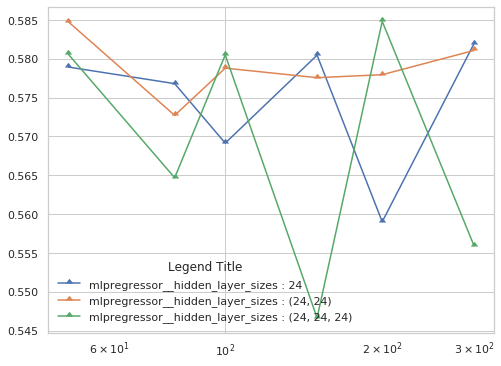

In [344]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


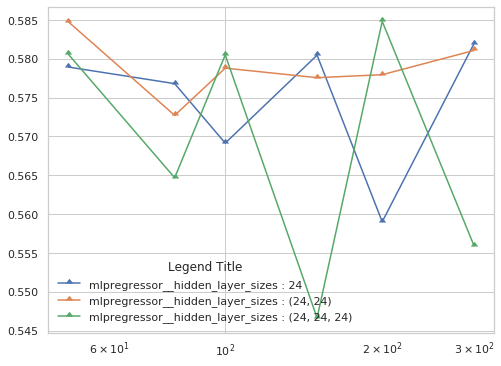

In [345]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


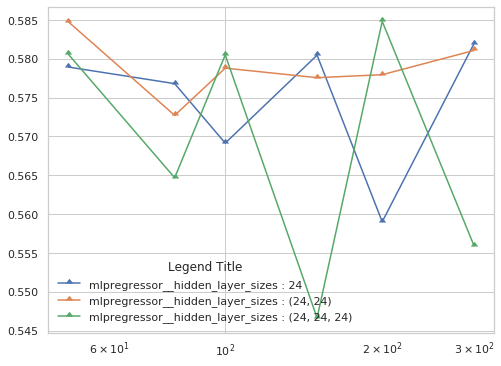

In [346]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [347]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [348]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376],
  [0.5113924302869325, -1.0485371949116327, -0.8366842201352647],
  [0.579909188095443, -0.971624379366445, -0.691170005069318],
  [0.5328721175777332, -1.0246850590633096, -0.5848874946415299],
  [0.582080709177899, -0.9686578890292472, -0.7143521785356891],
  [0.5765814969491694, -0.9755689528972, -0.6956609737599043],
  [0.584810504907355, -0.9660337250509148, -0.7257751730175824]]}

##### Consomation

In [349]:



params = {
    'mlpregressor__max_iter': [50,80, 100,150,200,300],
    'mlpregressor__hidden_layer_sizes':[(24), (24, 24),(24, 24, 24)],
    'mlpregressor__activation' : ['logistic'],
    'mlpregressor__solver': ["lbfgs"],
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [350]:
grid.cv_results_

{'mean_fit_time': array([0.24663286, 0.4250392 , 0.48702698, 0.67409577, 0.89799118,
        1.34898481, 0.46232748, 0.73092108, 0.90954089, 1.35062952,
        1.78573456, 2.65080409, 0.70373373, 1.11695328, 1.35762749,
        2.02580843, 2.6939343 , 4.02112522]),
 'std_fit_time': array([0.01899687, 0.00826663, 0.02510902, 0.01006532, 0.00905289,
        0.00653152, 0.00706897, 0.01642355, 0.00738502, 0.01593227,
        0.01195681, 0.02708044, 0.01677779, 0.01574904, 0.04200317,
        0.03690082, 0.0583321 , 0.07546204]),
 'mean_score_time': array([0.00870285, 0.00852232, 0.00833201, 0.00778074, 0.00784917,
        0.00773506, 0.0084022 , 0.00857639, 0.00855579, 0.00845108,
        0.00851974, 0.00856175, 0.00920067, 0.00935373, 0.0093287 ,
        0.00946627, 0.00918746, 0.0092937 ]),
 'std_score_time': array([1.88620813e-03, 2.82817236e-04, 4.04447082e-04, 4.54219369e-05,
        1.74982112e-04, 1.76934217e-05, 1.91659985e-04, 1.83812653e-04,
        2.46517368e-04, 3.46019787e-

In [351]:
paramList = list(params.keys())
np.shape(paramList)[0]

4

In [352]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]
    
    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7711843 pour les paramètres mlpregressor__max_iter : 300.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)

Le meilleur score de RMSE est : -0.5675625 pour les paramètres mlpregressor__max_iter : 300.0000000 et mlpregressor__hidden_layer_sizes : (24, 24, 24)

Le meilleur score de MAE est : -0.3785811 pour les paramètres mlpregressor__max_iter : 50.0000000 et mlpregressor__hidden_layer_sizes : 24


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


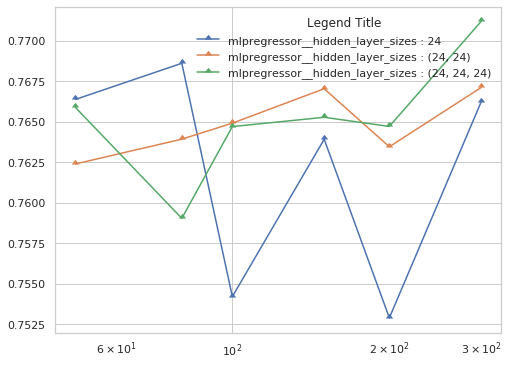

In [353]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


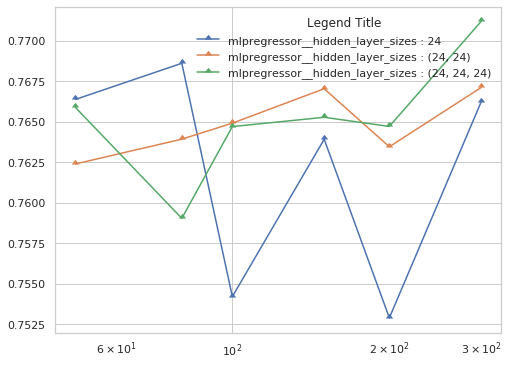

In [354]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


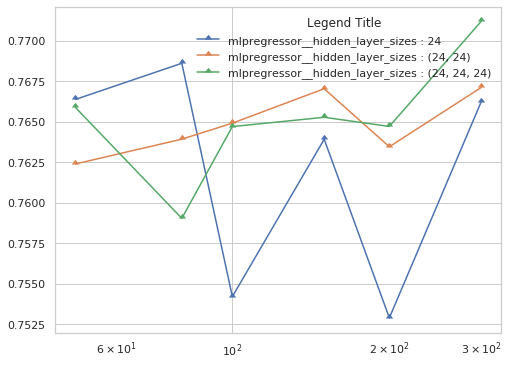

In [355]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [356]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [357]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179],
  [0.744692165604547, -0.6000462056856694, -0.40427336441391937],
  [0.775384867469244, -0.5618067715406535, -0.3576733817762874],
  [0.730400565681392, -0.6159292958088751, -0.33072808660704756],
  [0.7696204391688981, -0.568893794491012, -0.36929778296261934],
  [0.7754308714572932, -0.5616895866966419, -0.3561611872739751],
  [0.7711842819925007, -0.567562450052804, -0.37858113500549107]]}

#### forêts aléatoires

In [358]:
from sklearn.ensemble import RandomForestRegressor
model_ML = RandomForestRegressor()

In [359]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'RandomForestRegressor'

In [360]:
model = make_pipeline(preprocessor,model_ML)
print(model.steps)

[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['CouncilDistrictCode', 'YearBuilt',
                                  'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark',
                                  'logGFABuild']),
                                ('pipeline-2',
                                 Pipel...
                                 ['UType_Hotel', 'UType_K-12 School',
                                  'U

###### test des param pour nb arbre = 100.              'max_depth': [10,20,50,70], 'min_samples_leaf': (1, 5, 10),  max_features': (5, 10, 20)

In [361]:
RF_ERROR_EMI_noStar = {    
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
RF_ERROR_CONSO_noStar = {  
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

In [362]:
# evaluation : __max_depth
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 20),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_EMI_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_EMI_noStar




{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7211481154766307, -0.7907848388292265, -0.5337297293059123]]}

In [363]:
# evaluation : __min_samples_leaf
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
            'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 20),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_EMI_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_EMI_noStar





{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7211481154766307, -0.7907848388292265, -0.5337297293059123],
  [0.7213207796360745, -0.7904899190249634, -0.5353760502345329]]}

In [364]:
# evaluation : __max_features
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
            'randomforestregressor__max_features': (5, 10, 20),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_EMI_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_EMI_noStar

{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)],
  ['randomforestregressor__max_features', (5, 10, 20)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7211481154766307, -0.7907848388292265, -0.5337297293059123],
  [0.7213207796360745, -0.7904899190249634, -0.5353760502345329],
  [0.7351703132725873, -0.771090221260405, -0.5257107594138576]]}

In [365]:
print(params[paramList[1]])

(5, 10, 20)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

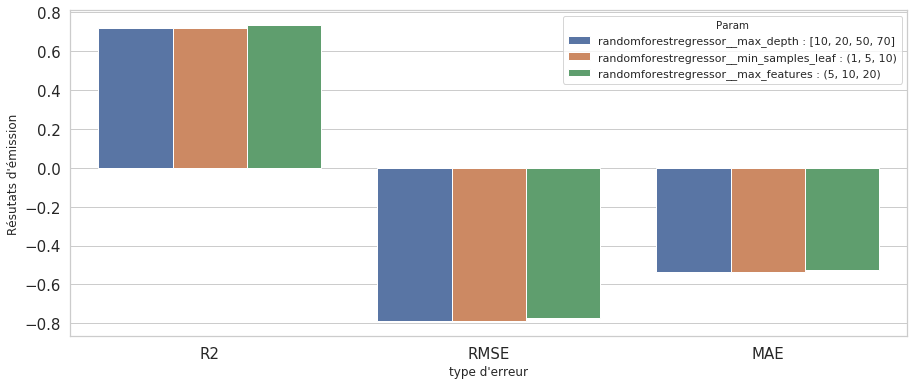

In [366]:
result = []
param = []
for k in range(3) : 
    for l in range(3) : 
        result.append(RF_ERROR_EMI_noStar["Resuts"][k][l])
        param.append(RF_ERROR_EMI_noStar["Param"][k][0] + " : " + str(RF_ERROR_EMI_noStar["Param"][k][1]))
d = {
    'Param' : param,
    "type d'erreur" : RF_ERROR_EMI_noStar["type d'erreur"]*3,
    "Résutats d'émission": result}

RF_resultatEMI_noStar= pd.DataFrame(data=d)

fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = RF_resultatEMI_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Param", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [367]:
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [10,20,50,70],
            'randomforestregressor__min_samples_leaf': (1, 5, 10),   
            'randomforestregressor__max_features': (5, 10, 20), 
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [368]:
grid.cv_results_

{'mean_fit_time': array([0.44446707, 0.34759927, 0.31648169, 0.56419091, 0.5134346 ,
        0.48509579, 0.93684835, 0.86242685, 0.81857071, 0.59662037,
        0.38921533, 0.34082632, 0.89382386, 0.60073452, 0.5210556 ,
        1.4525773 , 0.99633598, 0.8559309 , 0.6338707 , 0.37916465,
        0.33647103, 0.90230818, 0.59482145, 0.52061687, 1.46849384,
        1.00418701, 0.982723  , 0.63898964, 0.38459029, 0.33740606,
        0.91188006, 0.59974251, 0.52566361, 1.48673482, 1.08985071,
        0.87080398]),
 'std_fit_time': array([0.03819491, 0.01341924, 0.00164411, 0.00185313, 0.00299165,
        0.00630129, 0.00695659, 0.00347379, 0.02150568, 0.00358169,
        0.01006856, 0.00727013, 0.01578007, 0.00581083, 0.00725501,
        0.02872281, 0.00807109, 0.00994143, 0.00453219, 0.00170932,
        0.00329426, 0.00606512, 0.00598504, 0.0030602 , 0.01063122,
        0.01704603, 0.08626577, 0.00471838, 0.00838777, 0.00179648,
        0.00163667, 0.00536071, 0.00296617, 0.00875256, 0.086

In [369]:
resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

print("\nresultR2 : {} \nresultRMSE  : {} \nresultMAE : {} \n".format(resultR2,resultRMSE, resultMAE) )


ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])


resultR2 : 0.7365876618784611 
resultRMSE  : -0.7691372505011298 
resultMAE : -0.5245952479583272 



In [370]:
RF_resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
RF_resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
RF_resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

In [371]:
RF_resultR2

0.7365876618784611

###### selection features

In [372]:
params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],    
}



grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [373]:
                                                    
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],    
}                                                                                
                                                                                     
reg = RandomForestRegressor(max_depth=40,                                            
                    n_estimators=100,                                                
                    min_samples_leaf=1,                                                
                    max_features=10)                                                       
reg.fit(X_train_noStar, Y_train_noStarEMI)                                                                         
# pipe = make_pipeline(model, SelectFromModel(reg), clone(reg))                    
                                                                                     
# gs_pipe = GridSearchCV(pipe, param, cv=5, scoring="r2")                               
# gs_pipe.fit(X_train_noStar, Y_train_noStarEMI) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Feature ranking:
1. feature 5 (0.445221)
2. feature 1 (0.170513)
3. feature 3 (0.071256)
4. feature 16 (0.062442)
5. feature 0 (0.045345)
6. feature 8 (0.039050)
7. feature 4 (0.030758)
8. feature 10 (0.027953)
9. feature 9 (0.019149)
10. feature 12 (0.015853)
11. feature 18 (0.012248)
12. feature 14 (0.011209)
13. feature 13 (0.010516)
14. feature 11 (0.008685)
15. feature 6 (0.007289)
16. feature 17 (0.006353)
17. feature 2 (0.006142)
18. feature 19 (0.003813)
19. feature 7 (0.003153)
20. feature 20 (0.001616)
21. feature 15 (0.001437)


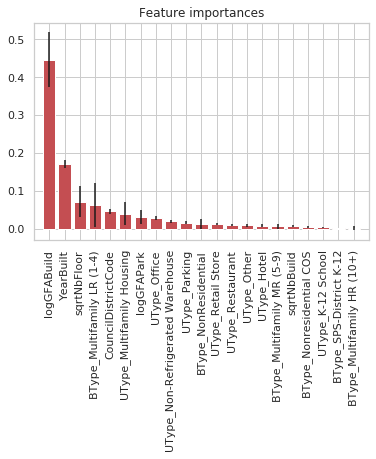

In [374]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_noStar.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_noStar.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_noStar.shape[1]), X_train_noStar.columns[indices])
plt.xlim([-1, X_train_noStar.shape[1]])
plt.xticks(rotation=90)
plt.show()

##### Consomation

###### test des param pour nb arbre = 100.              'max_depth': [10,20,50,70], 'min_samples_leaf': (1, 5, 10),  max_features': (5, 10, 20)

In [375]:
RF_ERROR_CONSO_noStar = {    
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }
RF_ERROR_CONSO_noStar = {  
    'Param':       [],\
    "type d'erreur":["R2", "RMSE", "MAE"],\
    'Resuts':       []\
                    }

In [376]:
# evaluation : __max_depth
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 20),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_CONSO_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_CONSO_noStar




{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8461472907816218, -0.46324539331814363, -0.2832243071833513]]}

In [377]:
# evaluation : __min_samples_leaf
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
            'randomforestregressor__min_samples_leaf': (1, 5, 10),   
#             'randomforestregressor__max_features': (5, 10, 20),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_CONSO_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_CONSO_noStar





{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8461472907816218, -0.46324539331814363, -0.2832243071833513],
  [0.8458632507587719, -0.46362829391957316, -0.28260514090206257]]}

In [378]:
# evaluation : __max_features
params = {
            'randomforestregressor__n_estimators': ([100]),    
#             'randomforestregressor__max_depth': [10,20,50,70],
#             'randomforestregressor__min_samples_leaf': (1, 5, 10),   
            'randomforestregressor__max_features': (5, 10, 20),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
RF_ERROR_CONSO_noStar['Param'].append([paramList[1], params[paramList[1]]])
RF_ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

RF_ERROR_CONSO_noStar

{'Param': [['randomforestregressor__max_depth', [10, 20, 50, 70]],
  ['randomforestregressor__min_samples_leaf', (1, 5, 10)],
  ['randomforestregressor__max_features', (5, 10, 20)]],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8461472907816218, -0.46324539331814363, -0.2832243071833513],
  [0.8458632507587719, -0.46362829391957316, -0.28260514090206257],
  [0.8555403998197354, -0.4489438325503185, -0.27466112736106296]]}

In [379]:
print(params[paramList[1]])

(5, 10, 20)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

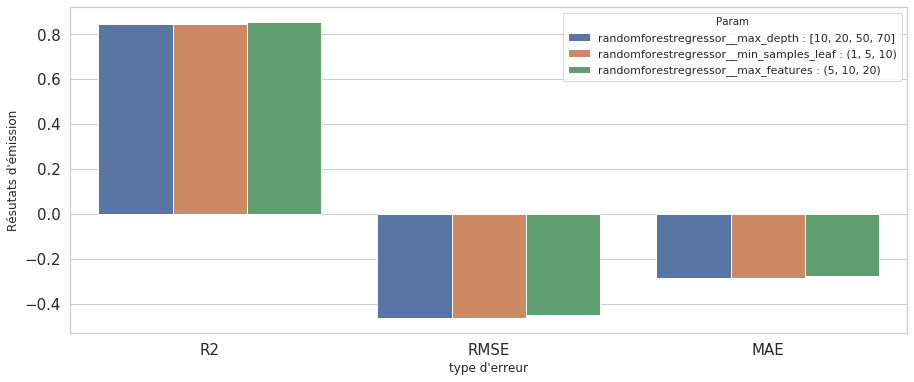

In [380]:
result = []
param = []
for k in range(3) : 
    for l in range(3) : 
        result.append(RF_ERROR_CONSO_noStar["Resuts"][k][l])
        param.append(RF_ERROR_CONSO_noStar["Param"][k][0] + " : " + str(RF_ERROR_CONSO_noStar["Param"][k][1]))
d = {
    'Param' : param,
    "type d'erreur" : RF_ERROR_CONSO_noStar["type d'erreur"]*3,
    "Résutats d'émission": result}

RF_resultatCONSO_noStar= pd.DataFrame(data=d)

fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = RF_resultatCONSO_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Param", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [381]:
params = {
            'randomforestregressor__n_estimators': ([100]),    
            'randomforestregressor__max_depth': [40,50,60],
            'randomforestregressor__min_samples_leaf': (1, 5),   
            'randomforestregressor__max_features': (10, 20, 24),    
}
grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [382]:
resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])

ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

###### selection features

In [385]:
from sklearn.feature_selection import SelectFromModel

params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],    
}                                                                                
                                                                                     
reg = RandomForestRegressor(max_depth=40,                                            
                    n_estimators=100,                                                
                    min_samples_leaf=1,                                                
                    max_features=10)                                                       
reg.fit(X_train_noStar, Y_train_noStarCONSO)                                                                         
) 

SyntaxError: invalid syntax (<ipython-input-385-599e82090f75>, line 15)

Feature ranking:
1. feature 5 (0.445221)
2. feature 1 (0.170513)
3. feature 3 (0.071256)
4. feature 16 (0.062442)
5. feature 0 (0.045345)
6. feature 8 (0.039050)
7. feature 4 (0.030758)
8. feature 10 (0.027953)
9. feature 9 (0.019149)
10. feature 12 (0.015853)
11. feature 18 (0.012248)
12. feature 14 (0.011209)
13. feature 13 (0.010516)
14. feature 11 (0.008685)
15. feature 6 (0.007289)
16. feature 17 (0.006353)
17. feature 2 (0.006142)
18. feature 19 (0.003813)
19. feature 7 (0.003153)
20. feature 20 (0.001616)
21. feature 15 (0.001437)


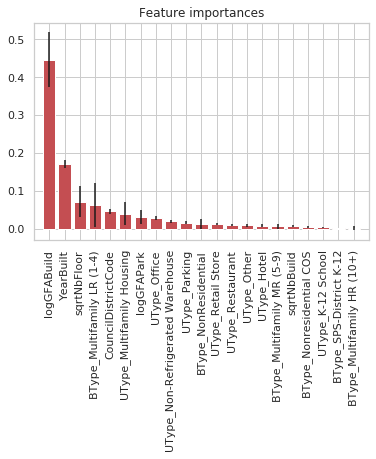

In [386]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_noStar.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_noStar.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_noStar.shape[1]), X_train_noStar.columns[indices])
plt.xlim([-1, X_train_noStar.shape[1]])
plt.xticks(rotation=90)
plt.show()

#### Gradient Boosting

In [73]:

from sklearn.ensemble import GradientBoostingRegressor
model_ML = GradientBoostingRegressor()

In [74]:
import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'GradientBoostingRegressor'

In [75]:
model = make_pipeline(preprocessor,model_ML)
model.steps

[('columntransformer',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                    transformer_weights=None,
                    transformers=[('pipeline-1',
                                   Pipeline(memory=None,
                                            steps=[('standardscaler',
                                                    StandardScaler(copy=True,
                                                                   with_mean=True,
                                                                   with_std=True))],
                                            verbose=False),
                                   ['CouncilDistrictCode', 'YearBuilt',
                                    'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark',
                                    'logGFABuild']),
                                  ('pipeline-2',
                                   Pipel...
                                   ['UType_Hotel', 'UType_K-12 School',
      

In [76]:



params = {
            'gradientboostingregressor__n_estimators': (100, 500, 800),
            'gradientboostingregressor__learning_rate': np.logspace(-3, 0, 5),    
            'gradientboostingregressor__max_depth': (3, 5),      
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [77]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [78]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.7153139 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279

Le meilleur score de RMSE est : -0.7998369 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279

Le meilleur score de MAE est : -0.4988187 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


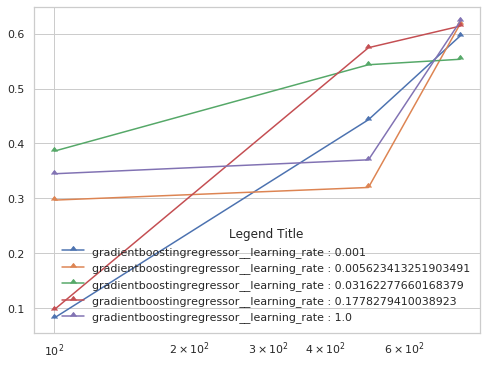

In [79]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


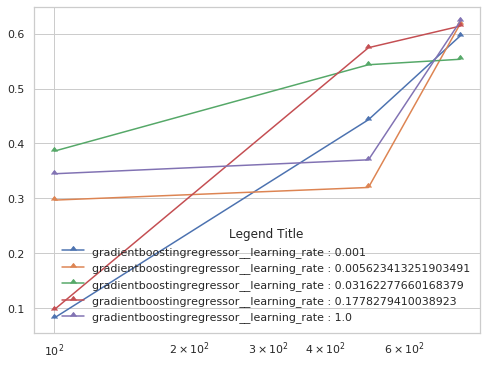

In [80]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


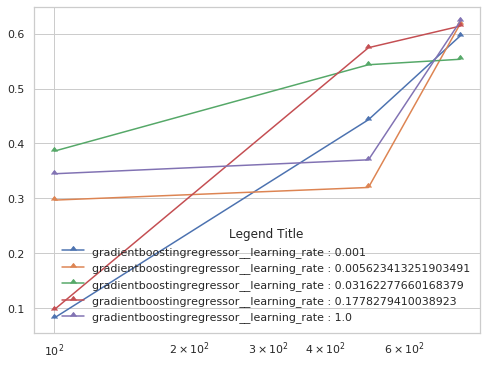

In [81]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [84]:
ERROR_EMI_noStar['Modèle'].append(model_name)
ERROR_EMI_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [85]:
ERROR_EMI_noStar

{'Modèle': ['GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7153138790096256, -0.7998368886801559, -0.4988187371294126]]}

In [398]:
paramList = list(params.keys())
result = grid.cv_results_['mean_test_r2']
bestScore = np.amax(result)
resultID = np.where(result == np.amax(result))
bestParam = grid.cv_results_["params"][resultID[0][0]]
bestParam 

{'gradientboostingregressor__learning_rate': 0.1778279410038923,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__n_estimators': 800}

##### Consomation

In [86]:



params = {
            'gradientboostingregressor__n_estimators': (100, 500, 800),
            'gradientboostingregressor__learning_rate': np.logspace(-3, 0, 5),    
            'gradientboostingregressor__max_depth': (3, 5),      
}

grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [87]:
grid.cv_results_

{'mean_fit_time': array([0.36424413, 1.69931288, 3.53557305, 0.75058241, 3.75302382,
        5.92749348, 0.46835833, 2.29378533, 3.64556074, 0.7499784 ,
        3.67480063, 5.8427979 , 0.46405935, 2.27442775, 3.64856224,
        0.74731112, 3.64506502, 5.82293673, 0.46126142, 2.2658721 ,
        3.63265233, 0.73337989, 3.63166108, 5.90008569, 0.45482602,
        2.2386745 , 3.57773571, 0.72483163, 3.59133725, 5.74378233]),
 'std_fit_time': array([0.02888534, 0.02704164, 0.56620855, 0.00497866, 0.08732902,
        0.00519122, 0.00403587, 0.0100951 , 0.00705575, 0.00742245,
        0.00299739, 0.00647348, 0.00441794, 0.00590864, 0.03392041,
        0.00073268, 0.00906833, 0.00657081, 0.00506586, 0.00643881,
        0.01145012, 0.00738039, 0.00379748, 0.18726176, 0.00632504,
        0.0057366 , 0.00188966, 0.00484033, 0.00310582, 0.00807572]),
 'mean_score_time': array([0.00432849, 0.00940881, 0.01807551, 0.00731812, 0.02037683,
        0.02968721, 0.00628667, 0.01367221, 0.01856108, 0.00

In [88]:
paramList = list(params.keys())
np.shape(paramList)[0]

3

In [89]:
if np.shape(paramList)[0] == 1 : 
    
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]] )  )

    resultMAE = bestScore
    
else :     
     
    result = grid.cv_results_['mean_test_r2']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "Le meilleur score de R2 est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultR2 = bestScore

    result = grid.cv_results_['mean_test_neg_root_mean_squared_error']
    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de RMSE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultRMSE = bestScore


    result = grid.cv_results_['mean_test_neg_mean_absolute_error']

    bestScore = np.amax(result)

    resultID = np.where(result == np.amax(result))
    bestParam = grid.cv_results_["params"][resultID[0][0]]

    print( "\nLe meilleur score de MAE est : {:3.7f} pour les paramètres {} : {:3.7f} et {} : {:3.7f}"
          .format(bestScore,paramList[0], bestParam[paramList[0]]  ,paramList[1], bestParam[paramList[1]] )  )

    resultMAE = bestScore
    
    
    


Le meilleur score de R2 est : 0.8531010 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279

Le meilleur score de RMSE est : -0.4536188 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279

Le meilleur score de MAE est : -0.2593254 pour les paramètres gradientboostingregressor__n_estimators : 800.0000000 et gradientboostingregressor__learning_rate : 0.1778279


/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


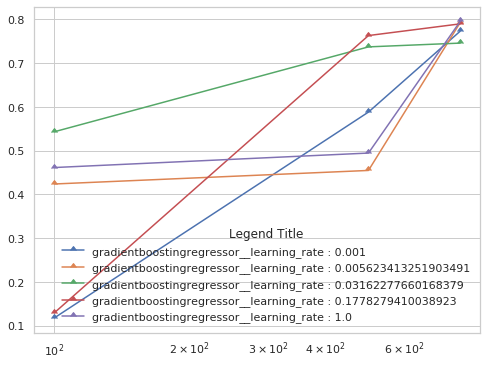

In [90]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_r2'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


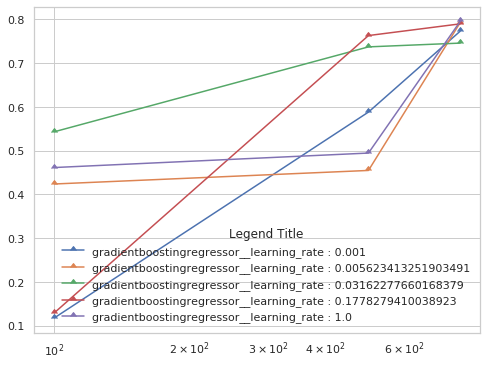

In [91]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

/home/ious/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


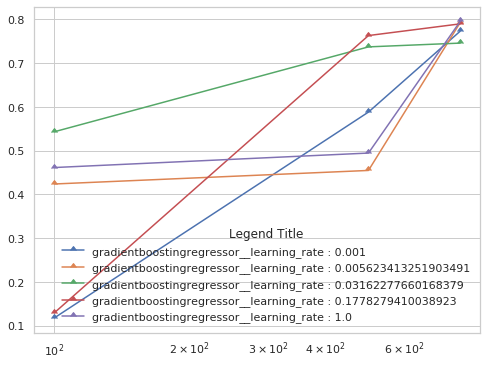

In [92]:
if np.shape(paramList)[0] == 1 : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[0]])[0]
    t = params[paramList[0]]
    s = []
    for j in range(L1) : 
        s.append(grid.cv_results_['mean_test_neg_mean_absolute_error'][j])
    ax.plot(t, s, marker=10)
    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)
else : 
    fig, ax = plt.subplots(1, figsize=(8, 6))

    L1 = np.shape(params[paramList[1]])[0]
    L2 = np.shape(params[paramList[0]])[0]


    for k in range(L1) : 
        t = params[paramList[0]]
        s = []
        for j in [(L1)*i + k for i in range(L2) ] : 
            s.append(grid.cv_results_['mean_test_r2'][j])
        ax.plot(t, s, label="{} : {}".format( paramList[1],  params[paramList[1]][k]), marker=10)

    ax.set_xscale('log')
    plt.legend(loc="higher left", title="Legend Title", frameon=False)

In [93]:
ERROR_CONSO_noStar['Modèle'].append(model_name)
ERROR_CONSO_noStar['Resuts'].append([resultR2, resultRMSE, resultMAE])

In [95]:
ERROR_CONSO_noStar

{'Modèle': ['GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.8531009873885562, -0.4536188295576095, -0.2593254490262208]]}

In [94]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# data_dmatrix = xgb.DMatrix(data=X_train_noStar,label=Y_train_noStarCONSO)

In [408]:
# model_ML = xgb.XGBRegressor()

In [409]:
# import re
# model_name = re.search("(^\w*)", str(model_ML)).group(0)
# model_name

In [410]:
# model = make_pipeline(preprocessor,model_ML)
# model.steps

In [411]:
# params = {
#             'xgbregressor__n_estimators': (100, 500, 1000),
# #             'xgbregressor__learning_rate': np.logspace(-3, 0, 5),    
# #             'xgbregressor__gamma': np.logspace(0, 3, 4),    
# }

# grid = GridSearchCV(model, param_grid=params, cv=5, scoring=score, refit = False)
# grid.fit(X_train,y_trainEMI)

In [412]:
# paramList = list(params.keys())
# result = grid.cv_results_['mean_test_r2']
# bestScore = np.amax(result)
# resultID = np.where(result == np.amax(result))
# bestParam = grid.cv_results_["params"][resultID[0][0]]
# print(bestParam)

# resultR2 = np.amax(grid.cv_results_['mean_test_r2'])
# resultRMSE = np.amax(grid.cv_results_['mean_test_neg_root_mean_squared_error'])
# resultMAE = np.amax(grid.cv_results_['mean_test_neg_mean_absolute_error'])
# print("\nXGBoost :\nresultR2 : {} \nresultRMSE  : {} \nresultMAE : {} \n".format(resultR2,resultRMSE, resultMAE) )


# print("\nRandom forest :\nresultR2 : {} \nresultRMSE  : {} \nresultMAE : {} \n".format(RF_resultR2,RF_resultRMSE, RF_resultMAE) )


### Résultats

#### Emission

In [413]:
ERROR_EMI_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.5113692856891261, -1.0485605581533934, -0.8367273529653376],
  [0.5113924302869325, -1.0485371949116327, -0.8366842201352647],
  [0.579909188095443, -0.971624379366445, -0.691170005069318],
  [0.5328721175777332, -1.0246850590633096, -0.5848874946415299],
  [0.582080709177899, -0.9686578890292472, -0.7143521785356891],
  [0.5765814969491694, -0.9755689528972, -0.6956609737599043],
  [0.584810504907355, -0.9660337250509148, -0.7257751730175824],
  [0.7365876618784611, -0.7691372505011298, -0.5245952479583272],
  [0.7164312341217016, -0.7983669949023959, -0.4983691126793963]]}

In [414]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(ERROR_EMI_noStar["Resuts"][k][l])
        model.append(ERROR_EMI_noStar["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_EMI_noStar["type d'erreur"]*np.shape(ERROR_EMI_noStar["Modèle"])[0],
    "Résutats d'émission": result}


In [415]:
d

{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 "Résutats d'émission": [0.5113692856891261,
  -1.0485605581533934,
  -0.8367273529653376,
  0.5113924302869325,
  -1.0485371949116327,
  -0.8366842201352647,
  0.579909188095443,
  -0.971624379366

In [416]:
resultatEMI_noStar= pd.DataFrame(data=d)
resultatEMI_noStar

Modèle type d'erreur  Résutats d'émission
0            LinearRegression            R2             0.511369
1            LinearRegression          RMSE            -1.048561
2            LinearRegression           MAE            -0.836727
3                  ElasticNet            R2             0.511392
4                  ElasticNet          RMSE            -1.048537
5                  ElasticNet           MAE            -0.836684
6                      SVRlin            R2             0.579909
7                      SVRlin          RMSE            -0.971624
8                      SVRlin           MAE            -0.691170
9         KNeighborsRegressor            R2             0.532872
10        KNeighborsRegressor          RMSE            -1.024685
11        KNeighborsRegressor           MAE            -0.584887
12                KernelRidge            R2             0.582081
13                KernelRidge          RMSE            -0.968658
14                KernelRidge           MAE            -0.714352
15                        SVR            R2             0.576581
16                        SVR          RMSE            -0.975569
17                        SVR           MAE            -0.695661
18               MLPRegressor            R2             0.584811
19               MLPRegressor          RMSE            -0.966034
20               MLPRegressor           MAE            -0.725775
21      RandomForestRegressor            R2             0.736588
22      RandomForestRegressor          RMSE            -0.769137
23      RandomForestRegressor           MAE            -0.524595
24  GradientBoostingRegressor            R2             0.716431
25  GradientBoostingRegressor          RMSE            -0.798367
26  GradientBoostingRegressor           MAE            -0.498369

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

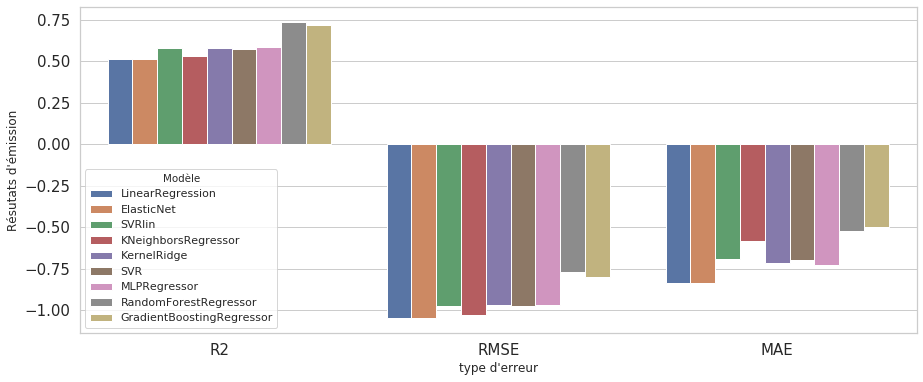

In [417]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatEMI_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#### Consomation

In [418]:
ERROR_CONSO_noStar

{'Modèle': ['LinearRegression',
  'ElasticNet',
  'SVRlin',
  'KNeighborsRegressor',
  'KernelRidge',
  'SVR',
  'MLPRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2', 'RMSE', 'MAE'],
 'Resuts': [[0.7446866719349535, -0.6000539239980097, -0.4042956701703179],
  [0.744692165604547, -0.6000462056856694, -0.40427336441391937],
  [0.775384867469244, -0.5618067715406535, -0.3576733817762874],
  [0.730400565681392, -0.6159292958088751, -0.33072808660704756],
  [0.7696204391688981, -0.568893794491012, -0.36929778296261934],
  [0.7754308714572932, -0.5616895866966419, -0.3561611872739751],
  [0.7711842819925007, -0.567562450052804, -0.37858113500549107],
  [nan, nan, nan],
  [0.8527588769649915, -0.454301751209638, -0.2598522290378269]]}

In [419]:
result = []
model = []
for k in range(9) : 
    for l in range(3) : 
        result.append(ERROR_CONSO_noStar["Resuts"][k][l])
        model.append(ERROR_CONSO_noStar["Modèle"][k])
d = {
    'Modèle' : model,
    "type d'erreur" : ERROR_CONSO_noStar["type d'erreur"]*np.shape(ERROR_CONSO_noStar["Modèle"])[0],
    "Résutats de consomation": result
}
d


{'Modèle': ['LinearRegression',
  'LinearRegression',
  'LinearRegression',
  'ElasticNet',
  'ElasticNet',
  'ElasticNet',
  'SVRlin',
  'SVRlin',
  'SVRlin',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KNeighborsRegressor',
  'KernelRidge',
  'KernelRidge',
  'KernelRidge',
  'SVR',
  'SVR',
  'SVR',
  'MLPRegressor',
  'MLPRegressor',
  'MLPRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor',
  'GradientBoostingRegressor'],
 "type d'erreur": ['R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE',
  'R2',
  'RMSE',
  'MAE'],
 'Résutats de consomation': [0.7446866719349535,
  -0.6000539239980097,
  -0.4042956701703179,
  0.744692165604547,
  -0.6000462056856694,
  -0.40427336441391937,
  0.775384867469244,
  -0.56180677

In [420]:
resultatCONSO_noStar= pd.DataFrame(data=d)
resultatCONSO_noStar

Modèle type d'erreur  Résutats de consomation
0            LinearRegression            R2                 0.744687
1            LinearRegression          RMSE                -0.600054
2            LinearRegression           MAE                -0.404296
3                  ElasticNet            R2                 0.744692
4                  ElasticNet          RMSE                -0.600046
5                  ElasticNet           MAE                -0.404273
6                      SVRlin            R2                 0.775385
7                      SVRlin          RMSE                -0.561807
8                      SVRlin           MAE                -0.357673
9         KNeighborsRegressor            R2                 0.730401
10        KNeighborsRegressor          RMSE                -0.615929
11        KNeighborsRegressor           MAE                -0.330728
12                KernelRidge            R2                 0.769620
13                KernelRidge          RMSE                -0.568894
14                KernelRidge           MAE                -0.369298
15                        SVR            R2                 0.775431
16                        SVR          RMSE                -0.561690
17                        SVR           MAE                -0.356161
18               MLPRegressor            R2                 0.771184
19               MLPRegressor          RMSE                -0.567562
20               MLPRegressor           MAE                -0.378581
21      RandomForestRegressor            R2                      NaN
22      RandomForestRegressor          RMSE                      NaN
23      RandomForestRegressor           MAE                      NaN
24  GradientBoostingRegressor            R2                 0.852759
25  GradientBoostingRegressor          RMSE                -0.454302
26  GradientBoostingRegressor           MAE                -0.259852

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

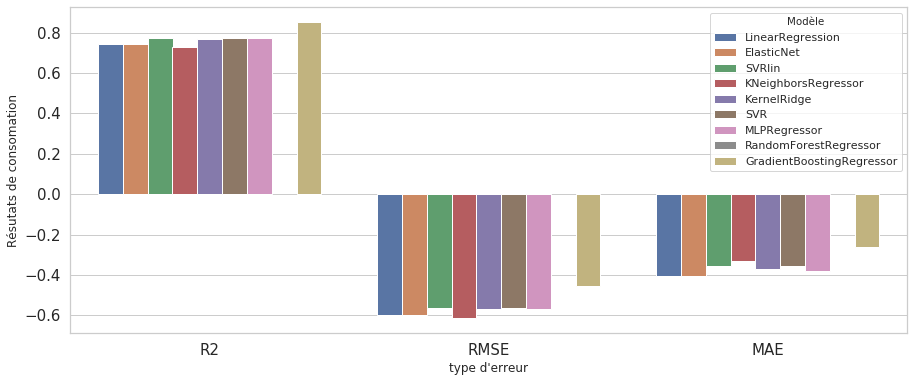

In [421]:
fig = plt.figure(figsize=(15,6))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = resultatCONSO_noStar
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Modèle", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#### Save result noStar

In [422]:
resultatEMI_noStar.to_csv('resultatEMI_noStar.csv', sep='\t', encoding='utf-8')
resultatCONSO_noStar.to_csv('resultatCONSO_noStar.csv', sep='\t', encoding='utf-8')


# Algorithme de descente de sélection de variables 

In [49]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import json

sns.set()


data = pd.read_csv('donneeIngFeaturing.csv', sep='\t')
targetEMI = "logEMI"
targetCONSO = "logCONSO"

In [50]:

data = data.drop(columns = ["Unnamed: 0", "Unnamed: 1"])
dataStar = data.dropna()
dataNoStar = data.drop(columns=["ENERGYSTARScore"]).dropna()

In [51]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import json

sns.set()

resultatEMI = pd.read_csv('resultatEMI.csv', sep='\t')
resultatCONSO = pd.read_csv('resultatCONSO.csv', sep='\t')


resultatEMI_noStar = pd.read_csv('resultatEMI_noStar.csv', sep='\t')
resultatCONSO_noStar = pd.read_csv('resultatCONSO_noStar.csv', sep='\t')

resultatEMI=resultatEMI.drop(columns="Unnamed: 0")
resultatCONSO=resultatCONSO.drop(columns="Unnamed: 0")
resultatEMI_noStar=resultatEMI_noStar.drop(columns="Unnamed: 0")
resultatCONSO_noStar=resultatCONSO_noStar.drop(columns="Unnamed: 0")

In [52]:
X_train_noStar = pd.read_csv('X_train_noStar.csv', sep='\t')

Y_train_noStar = pd.read_csv('Y_train_noStar.csv', sep='\t')


X_test_noStar = pd.read_csv('X_test_noStar.csv', sep='\t')

Y_test_noStar = pd.read_csv('Y_test_noStar.csv', sep='\t')


X_train_noStar=X_train_noStar.drop(columns="Unnamed: 0")
Y_train_noStar=Y_train_noStar.drop(columns="Unnamed: 0")
X_test_noStar=X_test_noStar.drop(columns="Unnamed: 0")
Y_test_noStar=Y_test_noStar.drop(columns="Unnamed: 0")

Y_train_noStarCONSO = Y_train_noStar["logCONSO"]
Y_train_noStarEMI = Y_train_noStar["logEMI"]

print(Y_train_noStarCONSO.shape)
print(Y_train_noStarEMI.shape)

(5212,)
(5212,)


In [53]:
print( "X Train {} et Y Train {} \n".format(X_train_noStar.shape,np.shape(Y_train_noStarEMI))  )

print( "CONSO X Train {} et Y Train {} \n".format(X_train_noStar.shape,np.shape(Y_train_noStarCONSO))  )

print( "X Test {} et Y Test{} \n".format(X_test_noStar.shape,np.shape(Y_test_noStar))  )

X Train (5212, 21) et Y Train (5212,) 

CONSO X Train (5212, 21) et Y Train (5212,) 

X Test (1303, 21) et Y Test(1303, 2) 



__Choix du modèle de forêt aléatoire !__

## Choix du jeu de donnée avec ou sans ENERGY STAR

In [54]:
bestEmi = resultatEMI.loc[resultatEMI['Modèle']  == "RandomForestRegressor"]
bestEmi_noStar = resultatEMI_noStar.loc[resultatEMI_noStar['Modèle']  == "RandomForestRegressor"]

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

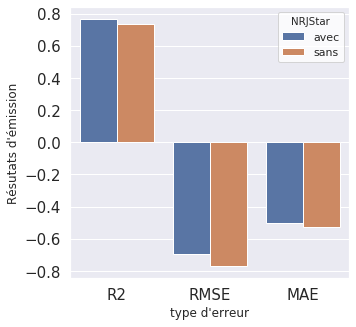

In [55]:
diffEMI_Star = bestEmi.copy()
diffEMI_Star["NRJStar"] = "avec"
diffEMI_Star["type d'erreur"] = bestEmi["type d'erreur"] 

diffEMI_noStar = bestEmi_noStar.copy()
diffEMI_noStar["NRJStar"] = "sans"
diffEMI_noStar["type d'erreur"] = bestEmi["type d'erreur"] 

diffEMI = pd.concat([diffEMI_Star, diffEMI_noStar])
diffEMI
fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffEMI
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="NRJStar", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [72]:
bestCONSO = resultatCONSO.loc[resultatCONSO['Modèle']  == "RandomForestRegressor"]
bestCONSO_noStar = resultatCONSO_noStar.loc[resultatCONSO_noStar['Modèle']  == "RandomForestRegressor"]
bestCONSO_noStar

Modèle type d'erreur  Résutats de consomation
21  RandomForestRegressor            R2                      NaN
22  RandomForestRegressor          RMSE                      NaN
23  RandomForestRegressor           MAE                      NaN

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

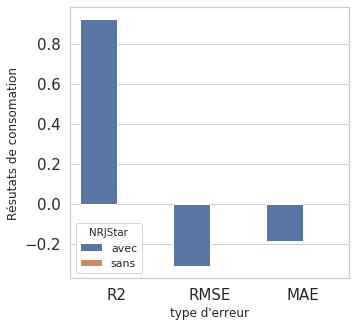

In [57]:
diffCONSO_Star = bestCONSO.copy()
diffCONSO_Star["NRJStar"] = "avec"
diffCONSO_Star["type d'erreur"] = bestCONSO["type d'erreur"] 

diffCONSO_noStar = bestCONSO_noStar.copy()
diffCONSO_noStar["NRJStar"] = "sans"
diffCONSO_noStar["type d'erreur"] = bestCONSO["type d'erreur"] 

diffCONSO = pd.concat([diffCONSO_Star, diffCONSO_noStar])
diffCONSO

fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffCONSO
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="NRJStar", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

__Choix de faire l'étude sans ENERGY STAR__

## Evaluation de l'erreur sur le jeu test

In [58]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(StandardScaler())
# categorical_pipeline = make_pipeline(FunctionTransformer())


In [59]:

numerical_features = ['CouncilDistrictCode', 'YearBuilt','sqrtNbBuild', 
                      'sqrtNbFloor', 'logGFAPark', 'logGFABuild']

categorical_features = dataNoStar.columns[15:].to_list()


In [60]:
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), 
    (categorical_pipeline, categorical_features))

In [61]:
from sklearn.ensemble import RandomForestRegressor

ERROR = {'EMI': [], 'CONSO': []}

model_ML = RandomForestRegressor()

model_name = re.search("(^\w*)", str(model_ML)).group(0)

model = make_pipeline(preprocessor,model_ML)


### Emission

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS



In [63]:

import re
model_name = re.search("(^\w*)", str(model_ML)).group(0)
model_name

'RandomForestRegressor'

##### Emission

In [64]:

score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]

In [65]:
params = {
        'randomforestregressor__n_estimators': [100],    
        'randomforestregressor__max_depth': [40],
        'randomforestregressor__min_samples_leaf': [1],   
        'randomforestregressor__max_features': [10],   
}

# score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]

grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [66]:
from sklearn.metrics import r2_score
y_true = Y_test_noStar["logEMI"]
y_pred = grid.predict(X_test_noStar)
err = r2_score(y_true, y_pred)
ERROR["EMI"].append(err)

In [67]:
from sklearn.metrics import mean_squared_error
err = np.sqrt(mean_squared_error(y_true, y_pred))
ERROR["EMI"].append(-err)

In [68]:
from sklearn.metrics import mean_absolute_error
err = mean_absolute_error(y_true, y_pred)
ERROR["EMI"].append(-err)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

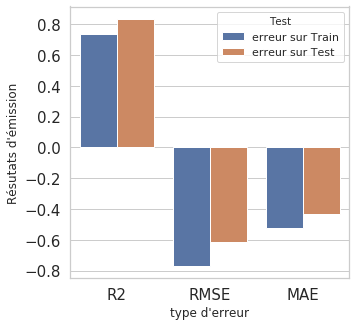

In [69]:
diffEMI_Train = bestEmi_noStar.copy()
diffEMI_Train["Test"] = "erreur sur Train"

diffEMI_True = bestEmi_noStar.copy()
diffEMI_True["Test"] = "erreur sur Test"
diffEMI_True["Résutats d'émission"] = ERROR["EMI"] 


diffEMI = pd.concat([diffEMI_Train, diffEMI_True])
diffEMI
fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffEMI
ax = sns.barplot(x="type d'erreur", y="Résutats d'émission", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

### Consomation

In [70]:
params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],      
}

# score = ['neg_root_mean_squared_error', "r2","neg_mean_absolute_error"]

grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
grid.fit(X_train_noStar,Y_train_noStarCONSO)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [71]:
from sklearn.metrics import r2_score
y_true = Y_test_noStar["logCONSO"]
y_pred = grid.predict(X_test_noStar)
err = r2_score(y_true, y_pred)
ERROR["CONSO"].append(err)

In [39]:
from sklearn.metrics import mean_squared_error
err = np.sqrt(mean_squared_error(y_true, y_pred))
ERROR["CONSO"].append(-err)

In [40]:
from sklearn.metrics import mean_absolute_error
err = mean_absolute_error(y_true, y_pred)
ERROR["CONSO"].append(-err)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

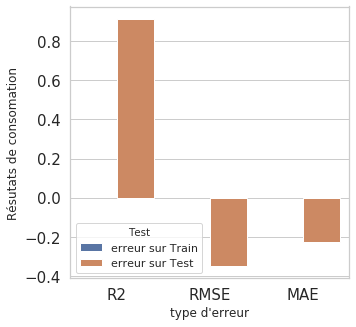

In [41]:
diffCONSO_Train = bestCONSO_noStar.copy()
diffCONSO_Train["Test"] = "erreur sur Train"

diffCONSO_True = bestCONSO_noStar.copy()
diffCONSO_True["Test"] = "erreur sur Test"
diffCONSO_True["Résutats de consomation"] = ERROR["CONSO"] 


diffCONSO = pd.concat([diffCONSO_Train, diffCONSO_True])
diffCONSO
fig = plt.figure(figsize=(5,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = diffCONSO
ax = sns.barplot(x="type d'erreur", y="Résutats de consomation", hue="Test", data=e)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

## ACP

### Analyse

In [42]:
from functions import *
from sklearn import decomposition

In [43]:
n_comp = 21
pca = decomposition.PCA(n_components = n_comp)

X_train_noStar_std = preprocessor.fit_transform(X_train_noStar)

pca.fit(X_train_noStar_std)


PCA(copy=True, iterated_power='auto', n_components=21, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

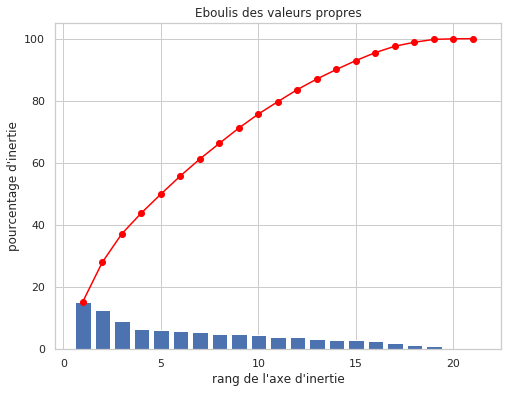

In [44]:

fig, ax = plt.subplots(1, figsize=(8, 6))

display_scree_plot(pca)


### reduction

In [45]:
from sklearn import decomposition


pca = decomposition.PCA()
model_ML = RandomForestRegressor(max_depth = 22, n_estimators=100)

model = make_pipeline(preprocessor,pca)




In [46]:
pipe = make_pipeline(model, model_ML)

pipe.steps

[('pipeline', Pipeline(memory=None,
           steps=[('columntransformer',
                   ColumnTransformer(n_jobs=None, remainder='drop',
                                     sparse_threshold=0.3,
                                     transformer_weights=None,
                                     transformers=[('pipeline-1',
                                                    Pipeline(memory=None,
                                                             steps=[('standardscaler',
                                                                     StandardScaler(copy=True,
                                                                                    with_mean=True,
                                                                                    with_std=True))],
                                                             verbose=False),
                                                    ['CouncilDistrictCode',
                                                     'Yea

In [47]:
params = {
    'pipeline__pca__n_components': [1,2,3,5,10, 20],
    'randomforestregressor__max_depth': [50],  
    'randomforestregressor__n_estimators': [100],  
}

grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring="r2", refit = True)


In [48]:
grid.fit(X_train_noStar,Y_train_noStarEMI)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pipeline',
                                        Pipeline(memory=None,
                                                 steps=[('columntransformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('pipeline-1',
                                                                                          Pipeline(memory=None,
                                                                                                   steps=[('standardscaler',
       

In [448]:
# params = {
#     'pipeline__pca__n_components': [10, 15],
#     'randomforestregressor__max_depth': [10,20],
#     'randomforestregressor__n_estimators': [50,100,150],    
# }

Text(0, 0.5, 'précision r2')

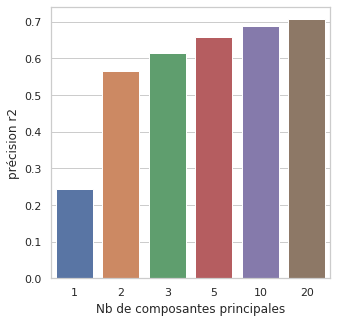

In [449]:
paramList = list(params.keys())
fig, ax = plt.subplots(1, figsize=(5, 5))

L1 = np.shape(params[paramList[1]])[0]
L2 = np.shape(params[paramList[0]])[0]


for k in range(L1) : 
    t = params[paramList[0]]
    s = []
    for j in [(L1)*i + k for i in range(L2) ] : 
        s.append(grid.cv_results_['mean_test_score'][j])
    sns.barplot(t, s)
ax.set_xlabel('Nb de composantes principales')
ax.set_ylabel('précision r2')
# plt.legend(loc="higher left", title="Legend Title", frameon=False)

## descente de selection de variable

In [96]:
X_train_noStar.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

In [97]:
import re

descente_colonne = X_train_noStar.columns[0:6].to_list()

colUType = []

for col in X_train_noStar.columns : 
    if re.search("^UType", col) : 
        colUType.append(col)

colBType = []

for col in X_train_noStar.columns : 
    if re.search("^BType", col) : 
        colBType.append(col)        

        
descente_colonne.append(colUType)
descente_colonne.append(colBType)
        
descente_colonne    
        
# X_descent


['CouncilDistrictCode',
 'YearBuilt',
 'sqrtNbBuild',
 'sqrtNbFloor',
 'logGFAPark',
 'logGFABuild',
 ['UType_Hotel',
  'UType_K-12 School',
  'UType_Multifamily Housing',
  'UType_Non-Refrigerated Warehouse',
  'UType_Office',
  'UType_Other',
  'UType_Parking',
  'UType_Restaurant',
  'UType_Retail Store'],
 ['BType_Multifamily HR (10+)',
  'BType_Multifamily LR (1-4)',
  'BType_Multifamily MR (5-9)',
  'BType_NonResidential',
  'BType_Nonresidential COS',
  'BType_SPS-District K-12']]

In [98]:

np.shape(descente_colonne)[0]

8

In [99]:
model_ML = RandomForestRegressor()
model_name = re.search("(^\w*)", str(model_ML)).group(0)

params = {'randomforestregressor__max_depth': [50],
          'randomforestregressor__n_estimators': [100],    
}
descente_X_train_noStar = X_train_noStar.copy()

ERROR_descente = []

ERROR_Full_descente = {
    'Iter': [],
    'colonne_eliminee': [],
    "score" : [],
}

for i in range(np.shape(descente_colonne)[0]) : 
    # boucle de 1 à 11 variables
    print("--------------------------------------------")
    print("\n\ni", i, np.shape(descente_X_train_noStar), descente_X_train_noStar.columns)
    ERROR_bestscore = {"col" : 0 , "score" : 0.  }

    # boucle pour determiner la meilleurs variables 

    descente_temp_X_train_noStar = descente_X_train_noStar.copy()

    for col_a_eliminer in descente_colonne : 
        print("\ncol_a_eliminer", col_a_eliminer)
        coltest = col_a_eliminer
        if type(col_a_eliminer) is list: coltest = col_a_eliminer[0]
        if coltest in (descente_X_train_noStar) : 
           

            descente_temp_X_train_noStar = descente_X_train_noStar.drop(columns = col_a_eliminer)

            print("ellimination reussi")

            preprocessor = make_column_transformer((numerical_pipeline, descente_temp_X_train_noStar.columns ))

            model = make_pipeline(preprocessor,model_ML)

            grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
            grid.fit(descente_temp_X_train_noStar,Y_train_noStarCONSO)

            if (ERROR_bestscore["score"]<grid.best_score_) : 
                ERROR_bestscore["col"] =  col_a_eliminer
                ERROR_bestscore["score"] =  grid.best_score_
            
            ERROR_Full_descente['Iter'].append(i)
            if re.search("^UType", coltest) : 
                ERROR_Full_descente['colonne_eliminee'].append("UType")
            else : 
                if re.search("^BType", coltest) : ERROR_Full_descente['colonne_eliminee'].append("BType")
                else :
                     ERROR_Full_descente['colonne_eliminee'].append(coltest)
            ERROR_Full_descente['score'].append(grid.best_score_)

            
            print("\n ------- \nERROR_Full_descente : {}\n ------- \n".format(ERROR_Full_descente))
            
            
        else : 
            print("pas de colonne", col_a_eliminer, "dans descente_X_train_noStar")
    
    descente_X_train_noStar = descente_X_train_noStar.drop(columns = ERROR_bestscore["col"])
    
    print("\n drop bonne colonne reussi : ", ERROR_bestscore["col"], print(np.shape(descente_X_train_noStar)))
    ERROR_descente.append(ERROR_bestscore)
    
    print("ERROR_descente", ERROR_descente)

--------------------------------------------


i 0 (5212, 21) Index(['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor',
       'logGFAPark', 'logGFABuild', 'UType_Hotel', 'UType_K-12 School',
       'UType_Multifamily Housing', 'UType_Non-Refrigerated Warehouse',
       'UType_Office', 'UType_Other', 'UType_Parking', 'UType_Restaurant',
       'UType_Retail Store', 'BType_Multifamily HR (10+)',
       'BType_Multifamily LR (1-4)', 'BType_Multifamily MR (5-9)',
       'BType_NonResidential', 'BType_Nonresidential COS',
       'BType_SPS-District K-12'],
      dtype='object')

col_a_eliminer CouncilDistrictCode
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0], 'colonne_eliminee': ['CouncilDistrictCode'], 'score': [0.8453164074349161]}
 ------- 


col_a_eliminer YearBuilt
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0, 0], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt'], 'score': [0.8453164074349161, 0.8373571841777719]}
 ------- 


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode'], 'score': [0.8453164074349161, 0.8373571841777719, 0.8471831811381761, 0.8448925583428984, 0.8332212963854613, 0.6729864741149807, 0.8321395849744773, 0.8435801021895031, 0.8455659152058225, 0.8374302208422766, 0.8455176645559532, 0.8342108119258465, 0.6827739327296095, 0.8332257815983303, 0.8480000722429033, 0.8439699068274219]}
 ------- 


col_a_eliminer YearBuilt
ellimination reussi

 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt',


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'CouncilDistrictCode', 'YearBuilt', 'logGFAPark'], 'score': [0.8453164074349161, 0.8373571841777719, 0.8471831811381761, 0.8448925583428984, 0.8332212963854613, 0.6729864741149807, 0.8321395849744773, 0.8435801021895031, 0.8455659152058225, 0.8374302208422766, 0.8455176645559532, 0.8342108119258465, 0.6827739327296095, 0.8332257815983303, 0.8480000722429033, 0.8439699068274219, 0.8343910978088835, 0.8452985277704392, 0.8340870464344006, 0.6796885785800442, 0.816318161022983, 0.8415950153101296, 0.8275488656110594, 0.8290849822417737]}
 ------- 


col_a_elim


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'CouncilDistrictCode', 'YearBuilt', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'logGFAPark', 'logGFABuild', 'UType'], 'score': [0.8453164074349161, 0.8373571841777719, 0.8471831811381761, 0.8448925583428984, 0.8332212963854613, 0.6729864741149807, 0.8321395849744773, 0.8435801021895031, 0.8455659152058225, 0.8374302208422766, 0.8455176645559532, 0.8342108119258465, 0.6827739327296095, 0.8332257815983303, 0.8480000722429033, 0.8439699068274219, 0.8343910978088835, 0.8452985277704392, 0.8340870464344006, 0.6796885785800442, 0.8163181


 ------- 
ERROR_Full_descente : {'Iter': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6], 'colonne_eliminee': ['CouncilDistrictCode', 'YearBuilt', 'sqrtNbBuild', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'BType', 'CouncilDistrictCode', 'YearBuilt', 'sqrtNbFloor', 'logGFAPark', 'logGFABuild', 'UType', 'CouncilDistrictCode', 'YearBuilt', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'logGFAPark', 'logGFABuild', 'UType', 'YearBuilt', 'logGFABuild', 'UType', 'logGFABuild'], 'score': [0.8453164074349161, 0.8373571841777719, 0.8471831811381761, 0.8448925583428984, 0.8332212963854613, 0.6729864741149807, 0.8321395849744773, 0.8435801021895031, 0.8455659152058225, 0.8374302208422766, 0.8455176645559532, 0.8342108119258465, 0.6827739327296095, 0.8332257815983303, 0.8480000722429033, 0.8439699068274219, 0.8343910978088835, 0.845

/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(4169, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(4169, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/home/ious/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(4170, 0)) while a minimum of 1 is required.

  FitF

ValueError: Found array with 0 feature(s) (shape=(5212, 0)) while a minimum of 1 is required.

In [ ]:
variable = []
resultr2 = []
for errorcol in ERROR_descente : 
    varCol = errorcol['col']
    if type(varCol) is list: 
        if re.search("^UType", varCol[0]) : varCol = "Usage Type"
        if re.search("^BType", varCol[0]) : varCol = "Building Type"
        
    variable.append(varCol)
    resultr2.append(errorcol['score'])
variable    

In [ ]:
ERROR_bestscore

In [ ]:
d = {
    'Variable' : variable,
    "Résutats r2": resultr2
}

ERROR_Full_descente = pd.DataFrame(ERROR_Full_descente)
ERROR_Full_descente

In [ ]:
descente_Result= pd.DataFrame(data=d)
descente_Result

In [ ]:
fig = plt.figure(figsize=(15,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
e = ERROR_Full_descente
ax = sns.barplot(x="Iter", y="score",hue="colonne_eliminee", data=e)
ax.legend(loc='lower left')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

In [ ]:
X_train_noStar

In [ ]:
params = {
            'randomforestregressor__n_estimators': [100],    
            'randomforestregressor__max_depth': [40],
            'randomforestregressor__min_samples_leaf': [1],   
            'randomforestregressor__max_features': [10],      
}

model = make_pipeline(preprocessor,model_ML)
grid = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", refit = True)
print(X_train_noStar)
print(Y_train_noStarCONSO)

In [ ]:
maxScore = np.max(ERROR_Full_descente.loc[ERROR_Full_descente["Iter"]==0]["score"])
# print(maxScore)

for  index, row in ERROR_Full_descente.loc[ERROR_Full_descente["Iter"]==0].iterrows(): 
    print("{} : {}".format(row["colonne_eliminee"],maxScore-row["score"]))

In [ ]:
ERROR_Full_descente